# Ubiquant market prediction : Modelisation
This is a notebook dedicated to do predictions with different modelisations concerning dataset of Ubiquant market prediction Kaggle competition.

Several ideas are picked up from this kernel https://www.kaggle.com/code/bastiendelaval/analyse-oc such as correlations and PCA.

## Librairies

In [2]:
# Data Manipulation
import numpy as np
import pandas as pd
import random
import datetime
from itertools import product

# Get files content
import os
import joblib

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import warnings

warnings.filterwarnings(action="ignore")

# scipy tools
from scipy.stats.stats import pearsonr

# sklearn tools
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    make_scorer,
)
from sklearn.model_selection import (
    learning_curve,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV,
    KFold,
    TimeSeriesSplit,
)

# XGBoost
from xgboost import XGBRegressor

# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

# Code formatting
%load_ext nb_black

<IPython.core.display.Javascript object>

## Data importation

We use parquet version of the dataset thanks to this kernel https://www.kaggle.com/code/camilomx/parquet-format-quickstart.

In [2]:
%%time

# Import dataset
path = "./train_low_mem.parquet"
df = pd.read_parquet(path)

CPU times: user 9.55 s, sys: 3.66 s, total: 13.2 s
Wall time: 2min 45s


<IPython.core.display.Javascript object>

In [26]:
# Dimension
df.shape

(3141410, 304)

<IPython.core.display.Javascript object>

## Get a sample dataset
Let's take a sample of the data.

In [53]:
sample_df = df.sample(frac=0.05, random_state=1)
sample_df

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
607231,270_482,270,482,1.393967,0.563777,0.329479,-1.315388,1.401520,0.016631,1.121079,...,0.847788,-0.819923,0.835474,0.319715,0.555386,0.556217,1.071587,-0.586470,-0.411992,0.412774
1435447,653_1885,653,1885,0.444124,-0.293736,0.655731,2.352335,0.026236,-0.572945,-0.872195,...,0.014079,-0.768240,-0.457168,0.472227,0.968007,-0.637575,-1.078555,-1.184083,-0.522147,-0.691200
1719449,759_3490,759,3490,0.280826,0.164325,0.872954,0.018527,-0.321309,-0.169804,-1.195469,...,-0.117692,1.045337,-0.246952,0.198558,-1.068690,-0.164562,-0.910962,0.178173,-0.027948,-0.385263
2166750,914_2149,914,2149,1.096577,0.941188,0.873456,-1.988921,2.852207,0.489025,1.074427,...,-1.242727,-1.019845,3.756444,0.844376,-1.028926,2.516795,1.265585,0.255740,0.758226,-0.830256
399169,176_3484,176,3484,-0.114734,0.869987,0.410584,1.002557,-0.255925,-0.539050,-1.188686,...,-0.753905,-0.516182,0.544362,0.150008,2.002837,-0.556329,-1.540250,0.551607,0.379718,-0.778006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248400,940_3636,940,3636,0.008491,0.935135,-1.455870,1.542440,-0.427455,-0.289459,-0.174019,...,-0.033160,0.862841,-0.355079,0.319239,1.099015,-0.516841,1.039523,-0.499201,1.388868,-0.535364
778810,350_919,350,919,-0.376004,-1.357517,-0.255878,0.837919,-1.442843,-0.489968,0.982652,...,-0.508619,-0.750760,-1.238941,0.099460,-1.539896,-0.880276,0.082330,-0.852978,1.616588,-0.303441
258031,113_3187,113,3187,-0.271133,0.714163,1.133366,0.130781,-0.394935,-0.343455,-0.903826,...,-0.381002,-0.588363,0.042733,0.385851,-0.609556,-0.363498,-0.129711,-0.550309,0.962057,-0.769098
2866111,1137_1967,1137,1967,-0.059472,-1.662638,0.263819,-0.863438,-0.418975,-0.195200,1.982726,...,0.107851,1.127201,-0.318118,1.135920,1.022511,-0.328731,1.280213,0.640524,0.185460,-0.297201


<IPython.core.display.Javascript object>

In [83]:
# Sort by time_id and investment_id to get data in order 
# and reset index
sample_df = sample_df.sort_values(
    ["time_id", "investment_id"], ascending=[True, True]
).reset_index(drop=True)
sample_df

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_19,0,19,0.685847,0.025283,-0.011870,-0.390564,-0.600695,-0.218549,1.253159,...,0.333684,0.912726,-0.122073,0.819155,-1.060166,-0.169155,0.104928,0.404938,-0.261311,-0.050004
1,0_98,0,98,0.586187,0.677165,-0.011870,-0.523899,0.419864,-0.114329,1.740953,...,-1.146118,0.912726,0.669720,0.819155,0.941183,-0.128453,1.296864,1.315424,-0.944005,-0.220631
2,0_173,0,173,1.076665,0.353120,0.615937,-0.082875,0.778190,0.159433,1.843599,...,0.366028,0.912726,1.797567,0.819155,-1.060166,0.884854,-1.087009,-1.365066,-1.132301,0.185581
3,0_315,0,315,1.121235,0.861542,1.494866,-0.089574,1.295896,0.006026,0.402792,...,-1.146118,0.912726,3.382770,0.819155,-1.060166,0.007830,-1.087009,0.297326,-1.429945,0.683604
4,0_335,0,335,3.161701,0.736542,0.113691,-1.845710,3.024322,-0.074793,1.738294,...,-0.609724,-1.095620,1.809639,-1.220772,-1.060166,0.267981,1.296864,-1.518155,0.887500,0.814394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157065,1219_3617,1219,3617,-1.081809,-0.015136,1.360878,1.454888,-0.448471,0.706850,-1.978520,...,0.137736,0.811402,0.138719,0.875537,0.421628,2.438486,1.363181,0.802745,1.019560,2.740571
157066,1219_3624,1219,3624,-1.027750,-0.685306,-0.720275,1.109542,-0.442211,-0.095155,0.119591,...,1.125366,0.811402,-0.477710,-1.142157,0.421628,-0.163245,-0.075548,0.166830,0.020751,-0.040690
157067,1219_3679,1219,3679,1.321338,0.688519,-0.590203,1.097954,-0.457912,-0.101383,0.555881,...,3.007065,0.811402,1.206952,-1.142157,0.421628,-0.334677,-1.514277,0.016244,0.097308,-0.155512
157068,1219_3759,1219,3759,-0.059480,0.498102,0.840589,0.310822,0.141530,0.500877,0.015716,...,-0.301501,0.811402,-0.282957,-1.142157,0.421628,1.311420,-1.514277,-0.808533,-1.034686,0.726296


<IPython.core.display.Javascript object>

In [84]:
# Save this dataset to csv
sample_df.to_csv("./sample_df.csv")

<IPython.core.display.Javascript object>

In [2]:
# Dictionnary of columns dtypes when reloading csv
data_types_dict = {
    "row_id": "object",
    "time_id": "uint16",
    "investment_id": "uint16",
    "target": "float32",
}

features = [f"f_{i}" for i in range(300)]

for f in features:
    data_types_dict[f] = "float32"

target = "target"

<IPython.core.display.Javascript object>

In [3]:
# Reload csv
sample_df = pd.read_csv(
    "./sample_df.csv",
    usecols=data_types_dict.keys(),
    dtype=data_types_dict,
    # index_col=0,
)
sample_df

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_19,0,19,0.685847,0.025283,-0.011870,-0.390564,-0.600695,-0.218549,1.253159,...,0.333684,0.912726,-0.122073,0.819155,-1.060166,-0.169155,0.104928,0.404938,-0.261311,-0.050004
1,0_98,0,98,0.586187,0.677165,-0.011870,-0.523899,0.419864,-0.114329,1.740953,...,-1.146118,0.912726,0.669720,0.819155,0.941183,-0.128453,1.296864,1.315424,-0.944005,-0.220631
2,0_173,0,173,1.076665,0.353120,0.615937,-0.082875,0.778190,0.159433,1.843599,...,0.366028,0.912726,1.797567,0.819155,-1.060166,0.884854,-1.087009,-1.365066,-1.132301,0.185581
3,0_315,0,315,1.121235,0.861542,1.494866,-0.089574,1.295896,0.006026,0.402792,...,-1.146118,0.912726,3.382770,0.819155,-1.060166,0.007830,-1.087009,0.297326,-1.429945,0.683604
4,0_335,0,335,3.161701,0.736542,0.113691,-1.845710,3.024322,-0.074793,1.738294,...,-0.609724,-1.095620,1.809639,-1.220772,-1.060166,0.267981,1.296864,-1.518155,0.887500,0.814394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157065,1219_3617,1219,3617,-1.081809,-0.015136,1.360878,1.454888,-0.448471,0.706850,-1.978520,...,0.137736,0.811402,0.138719,0.875537,0.421628,2.438486,1.363181,0.802745,1.019560,2.740571
157066,1219_3624,1219,3624,-1.027750,-0.685306,-0.720275,1.109542,-0.442211,-0.095155,0.119591,...,1.125366,0.811402,-0.477710,-1.142157,0.421628,-0.163245,-0.075548,0.166830,0.020751,-0.040690
157067,1219_3679,1219,3679,1.321338,0.688519,-0.590203,1.097954,-0.457912,-0.101383,0.555881,...,3.007065,0.811402,1.206952,-1.142157,0.421628,-0.334677,-1.514277,0.016244,0.097308,-0.155512
157068,1219_3759,1219,3759,-0.059480,0.498102,0.840589,0.310822,0.141530,0.500877,0.015716,...,-0.301501,0.811402,-0.282957,-1.142157,0.421628,1.311420,-1.514277,-0.808533,-1.034686,0.726296


<IPython.core.display.Javascript object>

In [4]:
# Dataframe information
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157070 entries, 0 to 157069
Columns: 304 entries, row_id to f_299
dtypes: float32(301), object(1), uint16(2)
memory usage: 182.1+ MB


<IPython.core.display.Javascript object>

### Get X_up and X_low
For more details on the procedure, see the notebook of analyse (Ubiquant_EDA.ipynb). Here we are only going to give code to get them.

In [91]:
# Compute correlation matrix with absolute values
corr_matrix = sample_df[features].corr().abs()

# Keep high correlations
high_corr_var = np.where(corr_matrix >= 0.80)

# Get pairs of features with high correlations
high_corr_var = [
    (corr_matrix.columns[x], corr_matrix.columns[y])
    for x, y in zip(*high_corr_var)
    if x != y and x < y
]
high_corr_var

[('f_4', 'f_228'),
 ('f_4', 'f_262'),
 ('f_17', 'f_169'),
 ('f_28', 'f_161'),
 ('f_39', 'f_97'),
 ('f_41', 'f_168'),
 ('f_41', 'f_246'),
 ('f_49', 'f_148'),
 ('f_49', 'f_205'),
 ('f_61', 'f_164'),
 ('f_72', 'f_95'),
 ('f_72', 'f_226'),
 ('f_82', 'f_234'),
 ('f_86', 'f_161'),
 ('f_95', 'f_148'),
 ('f_97', 'f_262'),
 ('f_97', 'f_288'),
 ('f_97', 'f_299'),
 ('f_100', 'f_243'),
 ('f_106', 'f_212'),
 ('f_121', 'f_274'),
 ('f_148', 'f_205'),
 ('f_157', 'f_211'),
 ('f_157', 'f_254'),
 ('f_211', 'f_254'),
 ('f_228', 'f_262'),
 ('f_240', 'f_274')]

<IPython.core.display.Javascript object>

In [15]:
# Select the lower triangle of the correlation matrix
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))
# k = -1 to remove values on diagonal

<IPython.core.display.Javascript object>

In [16]:
# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# k = 1 to remove values on diagonal

<IPython.core.display.Javascript object>

In [96]:
# Find features with correlation greater than 0.80 in lower matrix
to_drop_low = [column for column in lower.columns if any(lower[column] >= 0.8)]
print("{} features with high correlation (>=0.8)".format(len(to_drop_low)))

20 features with high correlation (>=0.8)


<IPython.core.display.Javascript object>

In [18]:
# Find features with correlation greater than 0.80 in upper matrix
to_drop_up = [column for column in upper.columns if any(upper[column] >= 0.8)]
print("{} features with high correlation (>=0.8)".format(len(to_drop_up)))

20 features with high correlation (>=0.8)


<IPython.core.display.Javascript object>

In [23]:
# Drop these features
sample_df_up = sample_df.drop(to_drop_up, axis=1)
sample_df_low = sample_df.drop(to_drop_low, axis=1)

<IPython.core.display.Javascript object>

In [24]:
print("sample_df_up shape : ", sample_df_up.shape)
print("sample_df_low shape : ", sample_df_low.shape)

sample_df_up shape :  (157070, 284)
sample_df_low shape :  (157070, 284)


<IPython.core.display.Javascript object>

In [25]:
# Remove others columns that are not "features"
others = ["row_id", "time_id", "investment_id", "target"]

features_up = list(sample_df_up.columns)
features_low = list(sample_df_low.columns)

for x in others:
    features_up.remove(x)
    features_low.remove(x)

<IPython.core.display.Javascript object>

In [26]:
len(features_up)

280

<IPython.core.display.Javascript object>

In [27]:
len(features_low)

280

<IPython.core.display.Javascript object>

## Split data
We are going to split data now in order that the test part is not influenced by operations done on the train part.

In [29]:
# Define X and y
X = sample_df[features].values
X_up = sample_df_up.drop(others, axis=1).values
X_low = sample_df_low.drop(others, axis=1).values
y = sample_df_up["target"].values

<IPython.core.display.Javascript object>

In [30]:
print("X shape : ", X.shape)
print("X_up shape : ", X_up.shape)
print("X_low shape : ", X_low.shape)
print("y shape : ", y.shape)

X shape :  (157070, 300)
X_up shape :  (157070, 280)
X_low shape :  (157070, 280)
y shape :  (157070,)


<IPython.core.display.Javascript object>

The test part has to be the end of the dataset as it is "the future" observations (remember that our data are ordered by time_id).

In [31]:
# Split data
X_train = X[:140000]
X_test = X[140000:]

X_up_train = X_up[:140000]
X_up_test = X_up[140000:]

X_low_train = X_low[:140000]
X_low_test = X_low[140000:]

y_train = y[:140000]
y_test = y[140000:]

print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("X_up_train shape : ", X_up_train.shape)
print("X_up_test shape : ", X_up_test.shape)
print("X_low_train shape : ", X_low_train.shape)
print("X_low_test shape : ", X_low_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (140000, 300)
X_test shape :  (17070, 300)
X_up_train shape :  (140000, 280)
X_up_test shape :  (17070, 280)
X_low_train shape :  (140000, 280)
X_low_test shape :  (17070, 280)
y_train shape :  (140000,)
y_test shape :  (17070,)


<IPython.core.display.Javascript object>

In [32]:
perc_test = round(len(X_up_test) / len(X_up) * 100, 1)
print("Percent of data in test set : {}%".format(perc_test))

Percent of data in test set : 10.9%


<IPython.core.display.Javascript object>

In [33]:
# Save data
joblib.dump(X_train, "./Data/X_train.joblib")
joblib.dump(X_test, "./Data/X_test.joblib")
joblib.dump(X_up_train, "./Data/X_up_train.joblib")
joblib.dump(X_low_train, "./Data/X_low_train.joblib")
joblib.dump(X_up_test, "./Data/X_up_test.joblib")
joblib.dump(X_low_test, "./Data/X_low_test.joblib")
joblib.dump(y_train, "./Data/y_train.joblib")
joblib.dump(y_test, "./Data/y_test.joblib")

['./Data/y_test.joblib']

<IPython.core.display.Javascript object>

In [3]:
# Load data
X_train = joblib.load("./Data/X_train.joblib")
X_test = joblib.load("./Data/X_test.joblib")
X_up_train = joblib.load("./Data/X_up_train.joblib")
X_low_train = joblib.load("./Data/X_low_train.joblib")
X_up_test = joblib.load("./Data/X_up_test.joblib")
X_low_test = joblib.load("./Data/X_low_test.joblib")
y_train = joblib.load("./Data/y_train.joblib")
y_test = joblib.load("./Data/y_test.joblib")

<IPython.core.display.Javascript object>

## Preprocessing

We are going to compare normalized data and unnormalized data. As mentioned in analysis notebook, we are going to use Robust Scaler for normalization.

### Scaling

In [4]:
# X
robust_scal = RobustScaler().fit(X_train)
X_scaled = robust_scal.transform(X_train)
X_scaled.shape

(140000, 300)

<IPython.core.display.Javascript object>

In [4]:
# Up
robust_scal_up = RobustScaler().fit(X_up_train)
X_up_scaled = robust_scal_up.transform(X_up_train)
X_up_scaled.shape

(140000, 280)

<IPython.core.display.Javascript object>

In [5]:
# Low
robust_scal_low = RobustScaler().fit(X_low_train)
X_low_scaled = robust_scal_low.transform(X_low_train)
X_low_scaled.shape

(140000, 280)

<IPython.core.display.Javascript object>

### PCA
We are going to consider PCA in order to decrease the number of features. We are going to keep 85% of explained variance (see notebook on analysis for more details).

In [4]:
# PCA 0.85 X
pca_85 = PCA(n_components=0.85, random_state=0)
pca_85.fit(X_train)
X_pca85 = pca_85.transform(X_train)
X_pca85.shape

(140000, 125)

<IPython.core.display.Javascript object>

The features number decreases of 58%.

In [7]:
# PCA 0.85 X_up
pca_up_85 = PCA(n_components=0.85, random_state=0)
pca_up_85.fit(X_up_train)
X_up_pca85 = pca_up_85.transform(X_up_train)
X_up_pca85.shape

(140000, 126)

<IPython.core.display.Javascript object>

The features number decreases of 55%.

In [8]:
# PCA 0.85 X_low
pca_low_85 = PCA(n_components=0.85, random_state=0)
pca_low_85.fit(X_low_train)
X_low_pca85 = pca_low_85.transform(X_low_train)
X_low_pca85.shape

(140000, 125)

<IPython.core.display.Javascript object>

The features number decreases of 55.4%.

In [10]:
# PCA 0.85 X_scaled
pca_scal_85 = PCA(n_components=0.85, random_state=0)
pca_scal_85.fit(X_scaled)
X_scal_pca85 = pca_scal_85.transform(X_scaled)
X_scal_pca85.shape

(140000, 10)

<IPython.core.display.Javascript object>

The features number decreases of 96.7% !

In [10]:
# PCA 0.85 X_up_scaled
pca_up_scal_85 = PCA(n_components=0.85, random_state=0)
pca_up_scal_85.fit(X_up_scaled)
X_up_scal_pca85 = pca_up_scal_85.transform(X_up_scaled)
X_up_scal_pca85.shape

(140000, 9)

<IPython.core.display.Javascript object>

The features number decreases of 96.8% !

In [11]:
# PCA 0.85 X_low_scaled
pca_low_scal_85 = PCA(n_components=0.85, random_state=0)
pca_low_scal_85.fit(X_low_scaled)
X_low_scal_pca85 = pca_low_scal_85.transform(X_low_scaled)
X_low_scal_pca85.shape

(140000, 9)

<IPython.core.display.Javascript object>

The features number decreases of 96.8% !

## Modelisation
### First Tries
We are going to see croos validation results with LinearRegression, ElasticNet and XGBoost using a cross validation split = 5.

#### Linear Regression
We are going to see on a simple linear regression how models perform with our different data (PCA, up, down, scaled..).

In [37]:
def display_learning_curve(model, X_train, y_train, name_model, name_X):

    """" Function to display learning curve for a model
    
    - Arguments : 
        - model : model to train
        - X_train : data to fit
        - y_train : data to compare
        - name_model : name of the model (string)
        - name_X : name of X_data (string)
    
    - Display :
        - Learning curve with training score and validation score
    
    """"
    N, train_score, val_score = learning_curve(
        model,
        X_train,
        y_train,
        cv=n_folds,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.1, 1, 10),
    )

    # Plot learning-curve
    plt.figure(figsize=(6, 6))
    plt.plot(N, -train_score.mean(axis=1), label="train_score")
    plt.plot(N, -val_score.mean(axis=1), label="validation_score")
    plt.xlabel("Dataset size", size=14)
    plt.ylabel("Mean RMSE", size=14)
    # plt.xlim([50,680])
    # plt.ylim([y_min, y_max])

    plt.title("Learning curve for {} with {}".format(name_model, name_X), size=14)
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>

In [106]:
def my_scorer(X, y):
    """
    Function to get Pearson correlation coefficient between X and y
    
    Arguments :
        - X
        _ y
    
    Returns :
        - Pearson correlation coefficient computed with 
        scipy.stats module
    """
    pearson = pearsonr(X, y)[0]
    return pearson

# Let's transform my_scorer has a scorer
my_pearson = make_scorer(my_scorer, greater_is_better=True)

# Dictionnay of scores
scoring = {
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "my_pearson": my_pearson,
}

<IPython.core.display.Javascript object>

In [105]:
def cross_val(model, X_train, y_train, name_model, name_X):

    """ Function to do cross-validation on a model and get scores in
    a dataframe 
        
    - Arguments :
        - model : model to test
        - X_train : X data 
        - y_train : X data
        - name_model : name of the model (string)
        - name_X : name given to the X data (string)
    
    - Return :
        - dataframe with name_model, name_X and scoring : RMSE, MAE, R2
    """

    # Cross validation
    scores = cross_validate(model, X_train, y_train, cv=n_folds, scoring=scoring,)

    # Get mean scores
    RMSE = -scores["test_neg_root_mean_squared_error"].mean()
    MAE = -scores["test_neg_mean_absolute_error"].mean()
    pearson = scores["test_my_pearson"].mean()

    # Dataframe creation for results
    df_model = pd.DataFrame(
        [[name_model, name_X, RMSE, MAE, pearson]],
        columns=["model", "X_data", "RMSE", "MAE", "Pearson_coef"],
    )

    return df_model

<IPython.core.display.Javascript object>

In [39]:
# Dico of X_data
dico_X = {
    "X_train": X_train,
    "X_scaled": X_scaled,
    "X_pca85": X_pca85,
    "X_scal_pca85": X_scal_pca85,
    "X_up_pca85": X_up_pca85,
    "X_up_scal_pca85": X_up_scal_pca85,
    "X_low_pca85": X_low_pca85,
    "X_low_scal_pca85": X_low_scal_pca85,
}

dico_X_scaled = {
    "X_scaled": X_scaled,
    "X_scal_pca85": X_scal_pca85,
    "X_up_scal_pca85": X_up_scal_pca85,
    "X_low_scal_pca85": X_low_scal_pca85,
}

small_dico_X = {
    "X_scal_pca85": X_scal_pca85,
    "X_up_scal_pca85": X_up_scal_pca85,
    "X_low_scal_pca85": X_low_scal_pca85,
}

small_dico_X_bis = {
    "X_pca85": X_pca85,
    "X_up_pca85": X_up_pca85,
    "X_low_pca85": X_low_pca85,
}

<IPython.core.display.Javascript object>

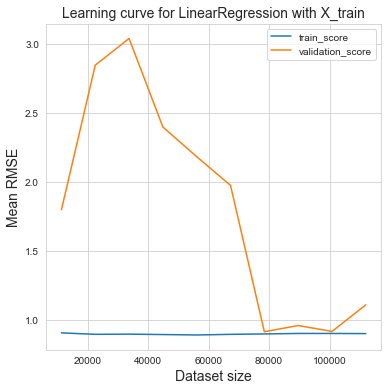

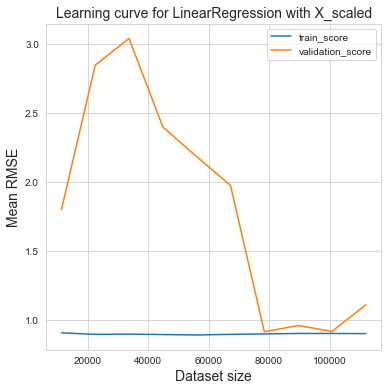

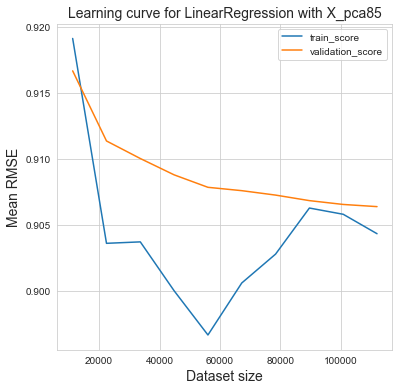

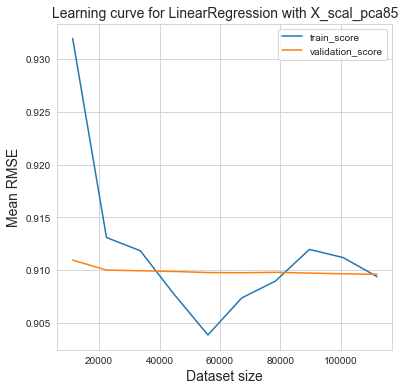

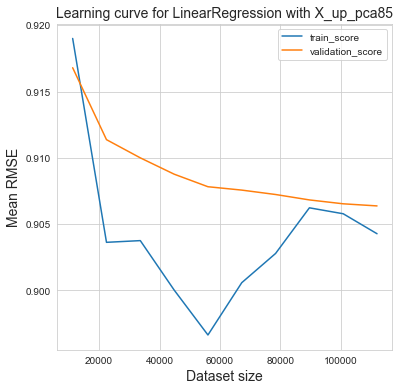

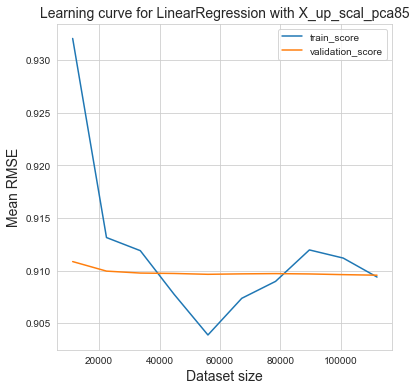

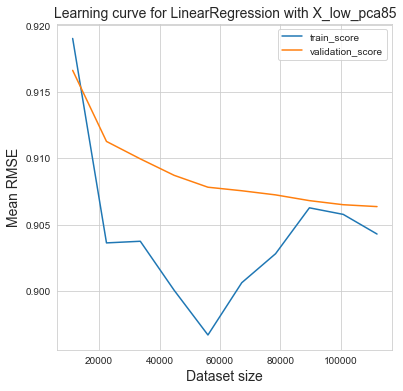

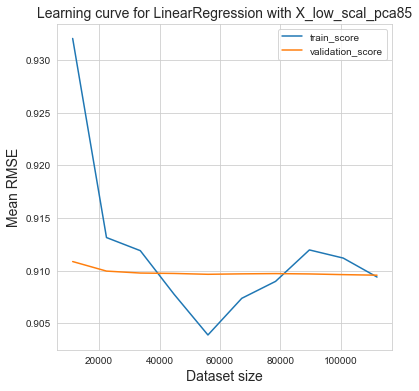

CPU times: user 5min 23s, sys: 45.4 s, total: 6min 8s
Wall time: 2min 6s


,model,X_data,RMSE,MAE,Pearson_coef
0,LinearRegression,X_train,1.110934,0.629592,0.088367
0,LinearRegression,X_scaled,1.110937,0.629592,0.088367
0,LinearRegression,X_pca85,0.906406,0.626232,0.113349
0,LinearRegression,X_scal_pca85,0.909609,0.628625,0.07427
0,LinearRegression,X_up_pca85,0.906378,0.626211,0.113574
0,LinearRegression,X_up_scal_pca85,0.909575,0.628586,0.074764
0,LinearRegression,X_low_pca85,0.906366,0.626175,0.113573
0,LinearRegression,X_low_scal_pca85,0.909572,0.628583,0.074812


<IPython.core.display.Javascript object>

In [29]:
%%time

model = LinearRegression()
n_folds = 5

# Dataframe for results
lr_results = pd.DataFrame(columns=[
            "model", "X_data", "RMSE", "MAE", "Pearson_coef",
        ])

# for each kind of X data
for name_X, X_data in dico_X.items() :
    
    # Learning curve
    display_learning_curve(model, X_data, y_train, "LinearRegression", name_X)
                           
    # Get results
    df_lr = cross_val(model, X_data, y_train, "LinearRegression", name_X)
    lr_results = pd.concat([lr_results, df_lr], axis = 0)

lr_results

In [34]:
lr_results = lr_results.reset_index(drop=True)
lr_results.sort_values(by = "RMSE")

,model,X_data,RMSE,MAE,Pearson_coef
6,LinearRegression,X_low_pca85,0.906366,0.626175,0.113573
4,LinearRegression,X_up_pca85,0.906378,0.626211,0.113574
2,LinearRegression,X_pca85,0.906406,0.626232,0.113349
7,LinearRegression,X_low_scal_pca85,0.909572,0.628583,0.074812
5,LinearRegression,X_up_scal_pca85,0.909575,0.628586,0.074764
3,LinearRegression,X_scal_pca85,0.909609,0.628625,0.07427
0,LinearRegression,X_train,1.110934,0.629592,0.088367
1,LinearRegression,X_scaled,1.110937,0.629592,0.088367


<IPython.core.display.Javascript object>

In [35]:
lr_results.sort_values(by = "MAE")

,model,X_data,RMSE,MAE,Pearson_coef
6,LinearRegression,X_low_pca85,0.906366,0.626175,0.113573
4,LinearRegression,X_up_pca85,0.906378,0.626211,0.113574
2,LinearRegression,X_pca85,0.906406,0.626232,0.113349
7,LinearRegression,X_low_scal_pca85,0.909572,0.628583,0.074812
5,LinearRegression,X_up_scal_pca85,0.909575,0.628586,0.074764
3,LinearRegression,X_scal_pca85,0.909609,0.628625,0.07427
0,LinearRegression,X_train,1.110934,0.629592,0.088367
1,LinearRegression,X_scaled,1.110937,0.629592,0.088367


<IPython.core.display.Javascript object>

In [37]:
lr_results.sort_values(by = "Pearson_coef", ascending=False)

,model,X_data,RMSE,MAE,Pearson_coef
4,LinearRegression,X_up_pca85,0.906378,0.626211,0.113574
6,LinearRegression,X_low_pca85,0.906366,0.626175,0.113573
2,LinearRegression,X_pca85,0.906406,0.626232,0.113349
1,LinearRegression,X_scaled,1.110937,0.629592,0.088367
0,LinearRegression,X_train,1.110934,0.629592,0.088367
7,LinearRegression,X_low_scal_pca85,0.909572,0.628583,0.074812
5,LinearRegression,X_up_scal_pca85,0.909575,0.628586,0.074764
3,LinearRegression,X_scal_pca85,0.909609,0.628625,0.07427


<IPython.core.display.Javascript object>

Metrics are close to each other.
We can see that top3 is the same for each metric.

In [35]:
# Save dataframe
joblib.dump(lr_results, "./Data/lr_results.joblib")

['./Data/lr_results.joblib']

<IPython.core.display.Javascript object>

#### ElasticNet
Let's try with ElasticNet, data must be scaled.

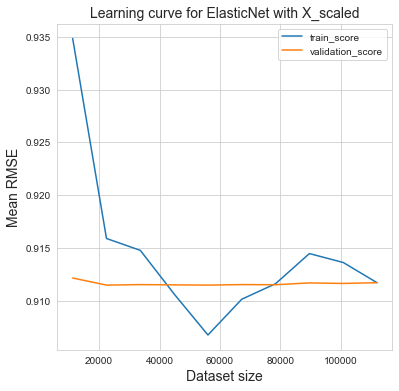

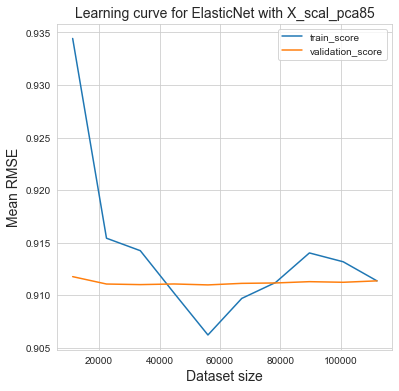

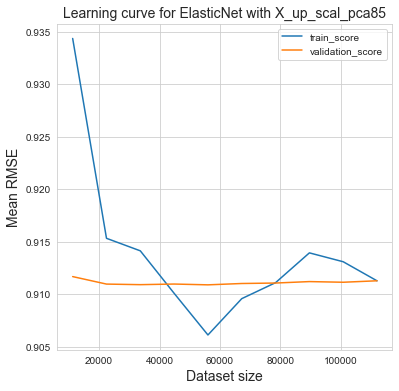

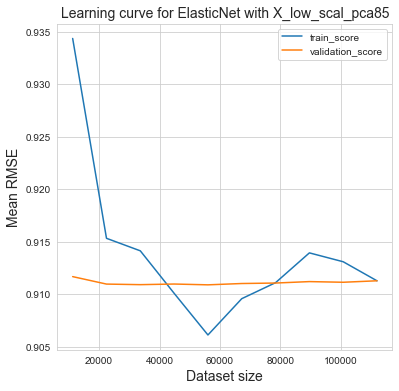

CPU times: user 35.7 s, sys: 14.1 s, total: 49.8 s
Wall time: 23.5 s


,model,X_data,RMSE,MAE,Pearson_coef
0,ElasticNet,X_scaled,0.911698,0.628998,0.045133
1,ElasticNet,X_scal_pca85,0.91136,0.628899,0.048648
2,ElasticNet,X_up_scal_pca85,0.911286,0.628858,0.052801
3,ElasticNet,X_low_scal_pca85,0.911281,0.628855,0.053039


<IPython.core.display.Javascript object>

In [44]:
%%time

model = ElasticNet()
n_folds = 5

# Dataframe for results
elast_results = pd.DataFrame(columns=[
            "model", "X_data", "RMSE", "MAE", "Pearson_coef",
        ])

# for each kind of X data
for name_X, X_data in dico_X_scaled.items() :
    
    # Learning curve
    display_learning_curve(model, X_data, y_train, "ElasticNet", name_X)
                           
    # Get results
    df_elast = cross_val(model, X_data, y_train, "ElasticNet", name_X)
    elast_results = pd.concat([elast_results, df_elast], axis = 0).reset_index(drop=True)

elast_results

As we can see, in some cases Pearson_coef cannot be performed.

In [45]:
elast_results.sort_values(by = "RMSE")

,model,X_data,RMSE,MAE,Pearson_coef
3,ElasticNet,X_low_scal_pca85,0.911281,0.628855,0.053039
2,ElasticNet,X_up_scal_pca85,0.911286,0.628858,0.052801
1,ElasticNet,X_scal_pca85,0.91136,0.628899,0.048648
0,ElasticNet,X_scaled,0.911698,0.628998,0.045133


<IPython.core.display.Javascript object>

In [46]:
elast_results.sort_values(by = "MAE")

,model,X_data,RMSE,MAE,Pearson_coef
3,ElasticNet,X_low_scal_pca85,0.911281,0.628855,0.053039
2,ElasticNet,X_up_scal_pca85,0.911286,0.628858,0.052801
1,ElasticNet,X_scal_pca85,0.91136,0.628899,0.048648
0,ElasticNet,X_scaled,0.911698,0.628998,0.045133


<IPython.core.display.Javascript object>

In [49]:
elast_results.sort_values(by = "Pearson_coef", ascending = False)

,model,X_data,RMSE,MAE,Pearson_coef
3,ElasticNet,X_low_scal_pca85,0.911281,0.628855,0.053039
2,ElasticNet,X_up_scal_pca85,0.911286,0.628858,0.052801
1,ElasticNet,X_scal_pca85,0.91136,0.628899,0.048648
0,ElasticNet,X_scaled,0.911698,0.628998,0.045133


<IPython.core.display.Javascript object>

Top 3 model is the same for each metric. Nevertheless, metrics are worse than LinearRegression. Hypertuning parameters may improve results.

#### XGboost
As it is a model that takes time, let's try on data with less features.

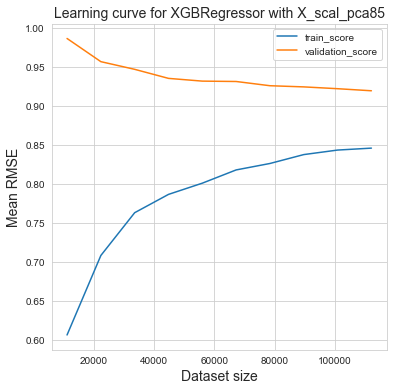

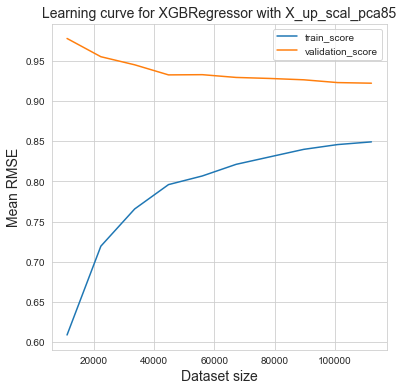

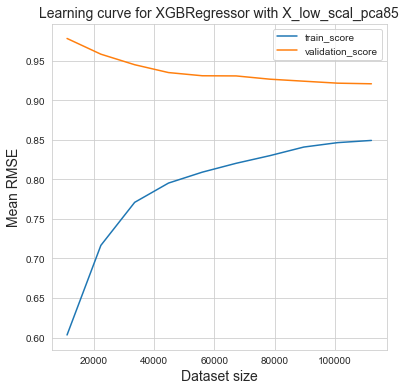

CPU times: user 51min 22s, sys: 1min 7s, total: 52min 30s
Wall time: 14min 55s


,model,X_data,RMSE,MAE,Pearson_coef
0,XGBRegressor,X_scal_pca85,0.919949,0.637183,0.04213
1,XGBRegressor,X_up_scal_pca85,0.92235,0.638047,0.029225
2,XGBRegressor,X_low_scal_pca85,0.921092,0.637511,0.034055


<IPython.core.display.Javascript object>

In [40]:
%%time

model = XGBRegressor()
n_folds = 5

# Dataframe for results
xg_results = pd.DataFrame(columns=[
            "model", "X_data", "RMSE", "MAE", "Pearson_coef",
        ])

# for each kind of X data
for name_X, X_data in small_dico_X.items() :
    
    # Learning curve
    display_learning_curve(model, X_data, y_train, "XGBRegressor", name_X)
                           
    # Get results
    df_xg = cross_val(model, X_data, y_train, "XGBRegressor", name_X)
    xg_results = pd.concat([xg_results, df_xg], axis = 0).reset_index(drop=True)

xg_results

Even if the learning curves are nice, metrics are worse than other models. We will need to tune hyperparameters.

### Using TimeSeriesSplit
We are going to split data in cross validation with TimeSeriesSplit.

In [18]:
# TimeSeriesSplit
ts_cv = TimeSeriesSplit(n_splits=5, test_size = 20000)

<IPython.core.display.Javascript object>

In [23]:
# Initiate counter
i = 1

# Get number of samples in each fold
for train_index, val_index in ts_cv.split(X_pca85):
    print(
        "Split ",
        i,
        "\nTrain nb of samples :",
        len(train_index),
        "Validation nb of samples :",
        len(val_index),
        "\n",
    )
    i += 1

Split  1 
Train nb of samples : 40000 Validation nb of samples : 20000 

Split  2 
Train nb of samples : 60000 Validation nb of samples : 20000 

Split  3 
Train nb of samples : 80000 Validation nb of samples : 20000 

Split  4 
Train nb of samples : 100000 Validation nb of samples : 20000 

Split  5 
Train nb of samples : 120000 Validation nb of samples : 20000 



<IPython.core.display.Javascript object>

#### Linear Regression

In [107]:
%%time

model = LinearRegression()
n_folds = ts_cv

# Dataframe for results
lr_results_ts_cv = pd.DataFrame(columns=[
            "model", "X_data", "RMSE", "MAE", "Pearson_coef",
        ])

# for each kind of X data
for name_X, X_data in dico_X.items() :
                           
    # Get results
    df_lr = cross_val(model, X_data, y_train, "LinearRegression", name_X)
    lr_results_ts_cv = pd.concat([lr_results_ts_cv, df_lr], axis = 0).reset_index(drop=True)

lr_results_ts_cv

CPU times: user 34.1 s, sys: 4.75 s, total: 38.8 s
Wall time: 13.8 s


,model,X_data,RMSE,MAE,Pearson_coef
0,LinearRegression,X_train,0.908742,0.621333,0.09949
1,LinearRegression,X_scaled,0.908742,0.621333,0.09949
2,LinearRegression,X_pca85,0.906316,0.618908,0.104369
3,LinearRegression,X_scal_pca85,0.9082,0.620276,0.072287
4,LinearRegression,X_up_pca85,0.906208,0.618814,0.105118
5,LinearRegression,X_up_scal_pca85,0.908131,0.620209,0.07328
6,LinearRegression,X_low_pca85,0.906225,0.618842,0.10491
7,LinearRegression,X_low_scal_pca85,0.908127,0.620206,0.07334


<IPython.core.display.Javascript object>

In [108]:
lr_results_ts_cv.sort_values(by="RMSE")

,model,X_data,RMSE,MAE,Pearson_coef
4,LinearRegression,X_up_pca85,0.906208,0.618814,0.105118
6,LinearRegression,X_low_pca85,0.906225,0.618842,0.10491
2,LinearRegression,X_pca85,0.906316,0.618908,0.104369
7,LinearRegression,X_low_scal_pca85,0.908127,0.620206,0.07334
5,LinearRegression,X_up_scal_pca85,0.908131,0.620209,0.07328
3,LinearRegression,X_scal_pca85,0.9082,0.620276,0.072287
1,LinearRegression,X_scaled,0.908742,0.621333,0.09949
0,LinearRegression,X_train,0.908742,0.621333,0.09949


<IPython.core.display.Javascript object>

Top 3 is the same, RMSE ans MAE are better, but Pearson_coef is worse (except when trained on all data).

We choose X_up_pca85 as best pre processed data and we are going to evaluate this model. 

In [115]:
# Put best model results on validation set in a dataframe
df_val = lr_results_ts_cv.sort_values(by="RMSE").head(1).drop(["MAE"], axis=1)
df_val

,model,X_data,RMSE,Pearson_coef
4,LinearRegression,X_up_pca85,0.906208,0.105118


<IPython.core.display.Javascript object>

In [42]:
# Create Pipeline
pipeline_lr = Pipeline(
    [("pca", PCA(n_components=0.85, random_state=0)), ("lr", LinearRegression()),]
)

# Model training
pipeline_lr.fit(X_up_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.85, random_state=0)),
                ('lr', LinearRegression())])

<IPython.core.display.Javascript object>

In [41]:
def get_scores(model, name_model, name_X, X_test, y_test):
    
    """
    Function to get target predictions and dataframe with
    metrics
    
    Arguments : 
    - model : model to evaluate
    - name_model : name of the model (string)
    - name_X : name of the data (string)
    - X_test : data to get predictions
    - y_test : actual target values
    
    Return :
    - y_pred : array of predictions values
    - results : dataframe with name_model, name_X, RMSE and
    Pearson_coef
    
    """

    # get predictions
    y_pred = model.predict(X_test)

    # Get scores
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    pearson = pearsonr(y_pred, y_test)[0]

    # Data frame for results
    results = pd.DataFrame(
        [[name_model, name_X, RMSE, pearson]],
        columns=["model", "X_data", "RMSE", "Pearson_coef"],
    )

    return y_pred, results

<IPython.core.display.Javascript object>

In [43]:
# Model evaluation
y_pred, lr_final = get_scores(
    pipeline_lr, "LinearRegression", "X_up_pca85", X_up_test, y_test
)
lr_final

,model,X_data,RMSE,Pearson_coef
0,LinearRegression,X_up_pca85,0.897627,0.094731


<IPython.core.display.Javascript object>

#### ElasticNet
We are going to optimize hyperparameters for ElasticNet with a GridSearCV. Don't forget to use scaled data.

In [120]:
def best_param(model, cv_split, X_train, hyper_params, scoring, name_model, name_X):
    
    """ Function to do cross-validation on a model and get scores in
    a dataframe 
        
    - Arguments :
        - model : model to test
        - cv_split : kind of split for cross validation
        - X_train : X data 
        - hyper_params : hyperparameters to use (dictionnary)
        - scoring : scores to use (dictionnary)
        - name_model : name of the model (string)
        - name_X : name given to the X data (string)
    
    - Return :
        - grid best estimator
        - dataframe with name_model, name_X and scoring : RMSE, MAE, R2
    """
    
    # Initiate GridSearchCV
    grid = GridSearchCV(
        model,
        param_grid=hyper_params,
        return_train_score=True,
        cv=cv_split,
        scoring=scoring,
        refit="my_pearson",
        n_jobs=-1,
    )

    # Train model
    grid.fit(X_train, y_train)

    # Display best parameters
    if len(hyper_params) != 0:
        print("Best parameters : ")
        for params, val in grid.best_params_.items():
            print(" - ", params, ":", val)

    for scorer in scoring:
        if scorer == "neg_root_mean_squared_error":
            # Best mean RMSE and std
            RMSE_mean_train = -grid.cv_results_["mean_train_%s" % scorer][
                grid.best_index_
            ]
            RMSE_mean_val = -grid.cv_results_["mean_test_%s" % scorer][grid.best_index_]
            RMSE_std_val = grid.cv_results_["std_test_%s" % scorer][grid.best_index_]

        else:
            # Best mean Pearson coefficient and std
            pearson_mean_train = grid.cv_results_["mean_train_%s" % scorer][
                grid.best_index_
            ]
            pearson_mean_val = grid.cv_results_["mean_test_%s" % scorer][
                grid.best_index_
            ]
            pearson_std_val = grid.cv_results_["std_test_%s" % scorer][grid.best_index_]

    # Model fit time
    mean_time = grid.cv_results_["mean_fit_time"][grid.best_index_]

    # Display results
    print("On validation set : ")
    print("- Mean RMSE : {:.5f} +/- {:.5f}".format(RMSE_mean_val, RMSE_std_val))
    print(
        "- Mean Pearson coefficient : {:.5f} +/- {:.5f}".format(
            pearson_mean_val, pearson_std_val
        )
    )
    print("- Fit Time : {:.3f} s \n".format(mean_time))

    # Get results in a dataFrame
    df_results = pd.DataFrame(
        [
            [
                name_model,
                name_X,
                round(mean_time, 3),
                round(RMSE_mean_train, 5),
                round(RMSE_mean_val, 5),
                round(pearson_mean_train, 5),
                round(pearson_mean_val, 5),
            ]
        ],
        columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
            "mean_pearson_coef_train",
            "mean_pearson_coef_validation",
        ],
    )

    return grid.best_estimator_, df_results

<IPython.core.display.Javascript object>

In [119]:
scoring = {
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "my_pearson": my_pearson,
}

<IPython.core.display.Javascript object>

In [121]:
%%time

# Model
model = ElasticNet(random_state = 42)

# Alpha = Constant that multiplies the penalty terms
alpha_range = np.logspace(-2, 2, 5) # default = 1.0

# l1_ratio 
l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9] # default = 0.5

# Tolerance for the optimization
tol_range = np.logspace(-6, -2, 5) # default = 1e-4

# Hyperparameters grid
hyper_params_elast = {'alpha': alpha_range, 
              'l1_ratio': l1_ratio,
             'tol' : tol_range}

# List of grid models
list_elast_grid = []

# Dataframe for results
elast_results_ts_cv = pd.DataFrame(columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
            "mean_pearson_coef_train",
            "mean_pearson_coef_validation",
        ])

for name_X, X_data in dico_X_scaled.items() :
    print(name_X,"------------")
    elast_grid, df_elast = best_param(
    model, ts_cv, X_data, hyper_params_elast, scoring, "ElasticNet", name_X
)
    elast_results_ts_cv = pd.concat([elast_results_ts_cv, df_elast], axis = 0).reset_index(drop=True)
    list_elast_grid.append(elast_grid)

X_scaled ------------
Best parameters : 
 -  alpha : 0.01
 -  l1_ratio : 0.1
 -  tol : 0.01
On validation set : 
- Mean RMSE : 0.90662 +/- 0.02299
- Mean Pearson coefficient : 0.10346 +/- 0.02721
- Fit Time : 15.769 s 

X_scal_pca85 ------------
Best parameters : 
 -  alpha : 0.1
 -  l1_ratio : 0.5
 -  tol : 1e-05
On validation set : 
- Mean RMSE : 0.90802 +/- 0.02129
- Mean Pearson coefficient : 0.07346 +/- 0.02188
- Fit Time : 0.023 s 

X_up_scal_pca85 ------------


/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.93705940246582, tolerance: 0.03354205936193466
  model = cd_fast.enet_coordinate_descent(
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.995972216129303, tolerance: 0.10053610801696777
  model = cd_fast.enet_coordinate_descent(
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.93705940246582, tolerance: 3.354205846786499
  model = cd_fast.enet_coordinate_descent(
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.605048656463623, tolerance: 0.08288402855396271
  model = cd_fast.enet_coordinate_descent(
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.605048656463623, tolerance: 0.8288403153419495
  model = cd_fast.enet_coordinate_descent(
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation

  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/pyt

Best parameters : 
 -  alpha : 0.1
 -  l1_ratio : 0.5
 -  tol : 1e-06
On validation set : 
- Mean RMSE : 0.90800 +/- 0.02134
- Mean Pearson coefficient : 0.07402 +/- 0.02215
- Fit Time : 0.017 s 

X_low_scal_pca85 ------------
Best parameters : 
 -  alpha : 0.1
 -  l1_ratio : 0.5
 -  tol : 1e-06
On validation set : 
- Mean RMSE : 0.90799 +/- 0.02135
- Mean Pearson coefficient : 0.07408 +/- 0.02216
- Fit Time : 0.016 s 

CPU times: user 27.2 s, sys: 4.59 s, total: 31.8 s
Wall time: 7min 1s


<IPython.core.display.Javascript object>

In [122]:
# Display results
elast_results_ts_cv

,model,X_data,mean_fit_time,mean_RMSE_train,mean_RMSE_validation,mean_pearson_coef_train,mean_pearson_coef_validation
0,ElasticNet,X_scaled,15.769,0.89858,0.90662,0.16471,0.10346
1,ElasticNet,X_scal_pca85,0.023,0.90772,0.90802,0.085,0.07346
2,ElasticNet,X_up_scal_pca85,0.017,0.90773,0.908,0.08472,0.07402
3,ElasticNet,X_low_scal_pca85,0.016,0.90773,0.90799,0.08477,0.07408


<IPython.core.display.Javascript object>

As we can see, it is on X_scaled that metrics are the best, even if it takes more time.

In [123]:
# Get best model results
df_els = elast_results_ts_cv.head(1).drop(
    ["mean_fit_time", "mean_RMSE_train", "mean_pearson_coef_train"], axis=1
)
df_els = df_els.rename(
    columns={
        "mean_RMSE_validation": "RMSE",
        "mean_pearson_coef_validation": "Pearson_coef",
    }
)
df_els

,model,X_data,RMSE,Pearson_coef
0,ElasticNet,X_scaled,0.90662,0.10346


<IPython.core.display.Javascript object>

In [124]:
# Concatenate results for validation set
df_val = pd.concat([df_val, df_els], axis=0).reset_index(drop=True)
df_val

,model,X_data,RMSE,Pearson_coef
0,LinearRegression,X_up_pca85,0.906208,0.105118
1,ElasticNet,X_scaled,0.90662,0.10346


<IPython.core.display.Javascript object>

In [125]:
# Get the params for best ElasticNet model
list_elast_grid[0]

ElasticNet(alpha=0.01, l1_ratio=0.1, random_state=42, tol=0.01)

<IPython.core.display.Javascript object>

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: 

In [29]:
# Create Pipeline
pipeline_elast = Pipeline(
    [("scal", RobustScaler()), 
     ("elast", ElasticNet(
         alpha=0.01, l1_ratio=0.1, random_state=42, tol=0.01)),]
)

# Model training
pipeline_elast.fit(X_train, y_train)

Pipeline(steps=[('scal', RobustScaler()),
                ('elast',
                 ElasticNet(alpha=0.01, l1_ratio=0.1, random_state=42,
                            tol=0.01))])

<IPython.core.display.Javascript object>

In [34]:
# Get scores
y_pred, elast_final = get_scores(
    pipeline_elast, "ElasticNet", "X_scaled", X_test, y_test
)
elast_final

,model,X_data,RMSE,Pearson_coef
0,ElasticNet,X_scaled,0.897163,0.098006


<IPython.core.display.Javascript object>

In [35]:
# Save model
joblib.dump(pipeline_elast, "./Data/pipeline_elast.joblib")

['./Data/pipeline_elast.joblib']

<IPython.core.display.Javascript object>

### XGBoost

#### Scikit Learn Grid Search
We are going to test XGboost model. As it takes long time, we first are going to do GridCV of scikit learn without considering Pearson coefficient. We are going to do it first on non scaled data.

Get also information in this kernel : https://www.kaggle.com/code/dansbecker/xgboost/notebook.

In [86]:
%%time

# Model
model = XGBRegressor()

scoring = "neg_root_mean_squared_error"

# max_depth
max_depth_range = [4,6,8] # default = 6.0

# Hyperparameters grid
hyper_params_elast = {'max_depth': max_depth_range}


# List of grid models
list_xg_grid = []

# Dataframe for results
xg_results = pd.DataFrame(columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
        ])

# GridSearch on non scaled data but with pca
for name_X, X_data in small_dico_X_bis.items() :
    print(name_X,"------------")
    xg_grid, df_xg = best_param2(
    model, ts_cv, X_data, hyper_params_elast, scoring, "XGBoost", name_X
)
    xg_results = pd.concat([xg_results, df_xg], axis = 0)
    list_xg_grid.append(xg_grid)

X_pca85 ------------
Best parameters : 
 -  max_depth : 4
On validation set : 
- Mean RMSE : 0.9201 +/- 0.0202
- Fit Time : 148.4249 s 

X_up_pca85 ------------
Best parameters : 
 -  max_depth : 4
On validation set : 
- Mean RMSE : 0.9200 +/- 0.0190
- Fit Time : 151.4143 s 

X_low_pca85 ------------
Best parameters : 
 -  max_depth : 4
On validation set : 
- Mean RMSE : 0.9203 +/- 0.0207
- Fit Time : 150.5436 s 

CPU times: user 13min 26s, sys: 3.02 s, total: 13min 29s
Wall time: 49min 13s


<IPython.core.display.Javascript object>

In [87]:
xg_results

,model,X_data,mean_fit_time,mean_RMSE_train,mean_RMSE_validation
0,XGBoost,X_pca85,148.4249,0.8301,0.9201
0,XGBoost,X_up_pca85,151.4143,0.8308,0.92
0,XGBoost,X_low_pca85,150.5436,0.8305,0.9203


<IPython.core.display.Javascript object>

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


It takes a long time.Let's do it now on scaled data with pca.

In [92]:
%%time

# Model
model = XGBRegressor()

scoring = "neg_root_mean_squared_error"

# max_depth
max_depth_range = [4,6,8] # default = 6.0

# Hyperparameters grid
hyper_params_elast = {'max_depth': max_depth_range}


# List of grid models
list_xg_grid_1 = []

# Dataframe for results
xg_results_1 = pd.DataFrame(columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
        ])

for name_X, X_data in small_dico_X.items() :
    print(name_X,"------------")
    xg_grid, df_xg = best_param2(
    model, ts_cv, X_data, hyper_params_elast, scoring, "XGBoost", name_X
)
    xg_results_1 = pd.concat([xg_results_1, df_xg], axis = 0)
    list_xg_grid_1.append(xg_grid)

X_scal_pca85 ------------
Best parameters : 
 -  max_depth : 4
On validation set : 
- Mean RMSE : 0.9171 +/- 0.0216
- Fit Time : 10.1855 s 

X_up_scal_pca85 ------------
Best parameters : 
 -  max_depth : 4
On validation set : 
- Mean RMSE : 0.9176 +/- 0.0220
- Fit Time : 12.0348 s 

X_low_scal_pca85 ------------
Best parameters : 
 -  max_depth : 4
On validation set : 
- Mean RMSE : 0.9168 +/- 0.0222
- Fit Time : 11.5708 s 

CPU times: user 1min 17s, sys: 1.36 s, total: 1min 18s
Wall time: 4min 26s


<IPython.core.display.Javascript object>

In [94]:
xg_results_1

,model,X_data,mean_fit_time,mean_RMSE_train,mean_RMSE_validation
0,XGBoost,X_scal_pca85,10.1855,0.8719,0.9171
0,XGBoost,X_up_scal_pca85,12.0348,0.874,0.9176
0,XGBoost,X_low_scal_pca85,11.5708,0.8741,0.9168


<IPython.core.display.Javascript object>

RMSE on validation set are better here than with no-scaled data and the search was quicker.

#### Manual GridSearch
We are going to use this procedure to do the hyperparameter tuning : https://towardsdatascience.com/beyond-grid-search-hypercharge-hyperparameter-tuning-for-xgboost-7c78f7a2929d

See also this notebook for XGBoost https://www.kaggle.com/code/dansbecker/xgboost/notebook

First we define a specific cross validation function.

In [44]:
EARLY_STOPPING_ROUNDS = 10  # stop if no improvement after 10 rounds

def my_cv(model, X_train, y_train, cv_folds, verbose=False):
    """Roll our own CV 
    train each kfold with early stopping
    return average metric, sd over kfolds, average best round"""
    
    RMSE = []
    pearson = []
    best_iterations = []
    
    for train_fold, cv_fold in cv_folds.split(X_train):
        # Get data for each fold split
        fold_X_train = X_train[train_fold]
        fold_y_train = y_train[train_fold]
        fold_X_val = X_train[cv_fold]
        fold_y_val = y_train[cv_fold]
        
        # train model
        model.fit(
            fold_X_train,
            fold_y_train,
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            eval_set=[(fold_X_val, fold_y_val)],
            eval_metric="rmse",
            verbose=verbose,
        )
        # get prediction
        y_pred_val = model.predict(fold_X_val)
        
        # get metrics
        RMSE.append(np.sqrt(mean_squared_error(fold_y_val, y_pred_val)))
        pearson.append(pearsonr(fold_y_val, y_pred_val)[0])
        best_iterations.append(model.best_iteration)
        
    return np.average(RMSE), np.std(RMSE), np.average(pearson), np.average(best_iterations)

<IPython.core.display.Javascript object>

In [131]:
BOOST_ROUNDS = 1000  # we use early stopping so make this arbitrarily high
RANDOMSTATE = 0

def cv_over_param_dict(param_dict, X_train, y_train, cv_folds, verbose=False):
    
    """given a list of dictionaries of xgb params
    run my_cv on params, store result in array
    return updated param_dict, results dataframe
    """

    start_time = datetime.datetime.now()
    print("%-20s %s" % ("Start Time", start_time))
    results = []

    for i, d in enumerate(param_dict):
        xgb = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=BOOST_ROUNDS,
            random_state=RANDOMSTATE,
            verbosity=1,
            n_jobs=-1,
            booster="gbtree",
            **d
        )

        metric_rmse, metric_std, pear_coef, best_iteration = my_cv(
            xgb, X_train, y_train, cv_folds, verbose=False
        )
        results.append([metric_rmse, metric_std, pear_coef, best_iteration, d])

        print(
            "%s %3d result RMSE mean: %.6f std: %.6f, Pearson_coef: %.6f, iter: %.2f"
            % (
                datetime.datetime.now().strftime("%T"),
                i,
                metric_rmse,
                metric_std,
                pear_coef,
                best_iteration,
            )
        )
    end_time = datetime.datetime.now()
    print("%-20s %s" % ("Start Time", start_time))
    print("%-20s %s" % ("End Time", end_time))
    print(str(datetime.timedelta(seconds=(end_time - start_time).seconds)))

    results_df = pd.DataFrame(
        results, columns=["RMSE", "std", "Pearson_coef", "best_iter", "param_dict"]
    ).sort_values("RMSE")
    display(results_df.head())

    best_params = results_df.iloc[0]["param_dict"]
    return best_params, results_df

<IPython.core.display.Javascript object>

In [132]:
# initial hyperparams (default values)
current_params = {
    "max_depth": 6,
    "colsample_bytree": 1,
    "colsample_bylevel": 1,
    "subsample": 1,
    "learning_rate": 0.3,
}

<IPython.core.display.Javascript object>

#### X_scal_pca85

##### Tuning max_depths

In [133]:
max_depths = list(range(2, 9))
grid_search_dicts = [{"max_depth": md} for md in max_depths]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [134]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_scal_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:02:23.280972
17:02:26   0 result RMSE mean: 0.907941 std: 0.020992, Pearson_coef: 0.072052, iter: 12.80
17:02:30   1 result RMSE mean: 0.908162 std: 0.021053, Pearson_coef: 0.069322, iter: 11.20
17:02:34   2 result RMSE mean: 0.908677 std: 0.021415, Pearson_coef: 0.064438, iter: 7.80
17:02:40   3 result RMSE mean: 0.909419 std: 0.021448, Pearson_coef: 0.059823, iter: 7.40
17:02:46   4 result RMSE mean: 0.910733 std: 0.021556, Pearson_coef: 0.052689, iter: 7.00
17:02:53   5 result RMSE mean: 0.912142 std: 0.021346, Pearson_coef: 0.044914, iter: 6.80
17:03:00   6 result RMSE mean: 0.912819 std: 0.021203, Pearson_coef: 0.045329, iter: 6.00
Start Time           2022-03-31 17:02:23.280972
End Time             2022-03-31 17:03:00.557604
0:00:37


,RMSE,std,Pearson_coef,best_iter,param_dict
0,0.907941,0.020992,0.072052,12.8,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
1,0.908162,0.021053,0.069322,11.2,"{'max_depth': 3, 'colsample_bytree': 1, 'colsa..."
2,0.908677,0.021415,0.064438,7.8,"{'max_depth': 4, 'colsample_bytree': 1, 'colsa..."
3,0.909419,0.021448,0.059823,7.4,"{'max_depth': 5, 'colsample_bytree': 1, 'colsa..."
4,0.910733,0.021556,0.052689,7.0,"{'max_depth': 6, 'colsample_bytree': 1, 'colsa..."


<IPython.core.display.Javascript object>

##### Tuning subsamples, colsample_bytrees, colsample_bylevel

In [135]:
# narrower search
subsamples = [0.1, 0.5, 1]
colsample_bytrees = [0.1, 0.5, 1]
colsample_bylevel = [0.1, 0.5, 1]

grid_search_dicts = [
    dict(zip(["subsample", "colsample_bytree", "colsample_bylevel"], [a, b, c]))
    for a, b, c in product(subsamples, colsample_bytrees, colsample_bylevel)
]

<IPython.core.display.Javascript object>

In [136]:
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_scal_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:03:26.488517
17:03:27   0 result RMSE mean: 0.909634 std: 0.020878, Pearson_coef: 0.046253, iter: 9.40
17:03:28   1 result RMSE mean: 0.909634 std: 0.020878, Pearson_coef: 0.046253, iter: 9.40
17:03:29   2 result RMSE mean: 0.909634 std: 0.020878, Pearson_coef: 0.046253, iter: 9.40
17:03:30   3 result RMSE mean: 0.909593 std: 0.020822, Pearson_coef: 0.047650, iter: 8.80
17:03:31   4 result RMSE mean: 0.909613 std: 0.021333, Pearson_coef: 0.051195, iter: 8.40
17:03:32   5 result RMSE mean: 0.909795 std: 0.021524, Pearson_coef: 0.053227, iter: 8.40
17:03:32   6 result RMSE mean: 0.909425 std: 0.020886, Pearson_coef: 0.054523, iter: 9.00
17:03:33   7 result RMSE mean: 0.909713 std: 0.021656, Pearson_coef: 0.056243, iter: 8.40
17:03:34   8 result RMSE mean: 0.909930 std: 0.021113, Pearson_coef: 0.054722, iter: 7.60
17:03:35   9 result RMSE mean: 0.908256 std: 0.020762, Pearson_coef: 0.064656, iter: 12.60
17:03:37  10 result RMSE mean: 0.908256 std: 0.0207

,RMSE,std,Pearson_coef,best_iter,param_dict
25,0.907642,0.020828,0.074521,13.4,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
23,0.907811,0.020991,0.073200,11.2,"{'max_depth': 2, 'colsample_bytree': 0.5, 'col..."
22,0.907825,0.021041,0.072966,11.0,"{'max_depth': 2, 'colsample_bytree': 0.5, 'col..."
14,0.907907,0.021500,0.072550,12.4,"{'max_depth': 2, 'colsample_bytree': 0.5, 'col..."
26,0.907941,0.020992,0.072052,12.8,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."


<IPython.core.display.Javascript object>

In [137]:
# Display current_params
current_params

{'max_depth': 2,
 'colsample_bytree': 1,
 'colsample_bylevel': 0.5,
 'subsample': 1,
 'learning_rate': 0.3}

<IPython.core.display.Javascript object>

##### Tuning learning_rate

In [138]:
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7]
grid_search_dicts = [{"learning_rate": lr} for lr in learning_rates]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [139]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_scal_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:04:21.350815
17:04:46   0 result RMSE mean: 0.907808 std: 0.020946, Pearson_coef: 0.073101, iter: 361.60
17:04:52   1 result RMSE mean: 0.907784 std: 0.020901, Pearson_coef: 0.072819, iter: 85.20
17:04:56   2 result RMSE mean: 0.907771 std: 0.020988, Pearson_coef: 0.073644, iter: 41.20
17:04:58   3 result RMSE mean: 0.907671 std: 0.020971, Pearson_coef: 0.075093, iter: 19.80
17:05:00   4 result RMSE mean: 0.907642 std: 0.020828, Pearson_coef: 0.074521, iter: 13.40
17:05:02   5 result RMSE mean: 0.907888 std: 0.020931, Pearson_coef: 0.071875, iter: 5.40
17:05:03   6 result RMSE mean: 0.908274 std: 0.020911, Pearson_coef: 0.067250, iter: 2.60
Start Time           2022-03-31 17:04:21.350815
End Time             2022-03-31 17:05:03.497993
0:00:42


,RMSE,std,Pearson_coef,best_iter,param_dict
4,0.907642,0.020828,0.074521,13.4,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
3,0.907671,0.020971,0.075093,19.8,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
2,0.907771,0.020988,0.073644,41.2,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
1,0.907784,0.020901,0.072819,85.2,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
0,0.907808,0.020946,0.073101,361.6,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."


<IPython.core.display.Javascript object>

Here we can see that best RMSE does not fit with best pearson coefficient. So let's try other values for alpha around 0.2 and 0.3

In [140]:
current_params

{'max_depth': 2,
 'colsample_bytree': 1,
 'colsample_bylevel': 0.5,
 'subsample': 1,
 'learning_rate': 0.3}

<IPython.core.display.Javascript object>

In [141]:
learning_rates = [0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34]
grid_search_dicts = [{"learning_rate": lr} for lr in learning_rates]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [142]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_scal_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:07:24.651694
17:07:27   0 result RMSE mean: 0.907685 std: 0.020957, Pearson_coef: 0.075551, iter: 21.60
17:07:29   1 result RMSE mean: 0.907671 std: 0.020971, Pearson_coef: 0.075093, iter: 19.80
17:07:31   2 result RMSE mean: 0.907749 std: 0.020963, Pearson_coef: 0.073838, iter: 16.00
17:07:33   3 result RMSE mean: 0.907795 std: 0.020886, Pearson_coef: 0.072480, iter: 14.00
17:07:35   4 result RMSE mean: 0.907786 std: 0.020792, Pearson_coef: 0.073122, iter: 12.80
17:07:37   5 result RMSE mean: 0.907704 std: 0.020826, Pearson_coef: 0.074160, iter: 15.40
17:07:39   6 result RMSE mean: 0.907642 std: 0.020828, Pearson_coef: 0.074521, iter: 13.40
17:07:41   7 result RMSE mean: 0.907904 std: 0.021053, Pearson_coef: 0.070983, iter: 12.20
17:07:42   8 result RMSE mean: 0.907793 std: 0.021055, Pearson_coef: 0.073092, iter: 11.00
Start Time           2022-03-31 17:07:24.651694
End Time             2022-03-31 17:07:42.883770
0:00:18


,RMSE,std,Pearson_coef,best_iter,param_dict
6,0.907642,0.020828,0.074521,13.4,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
1,0.907671,0.020971,0.075093,19.8,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
0,0.907685,0.020957,0.075551,21.6,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
5,0.907704,0.020826,0.074160,15.4,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
2,0.907749,0.020963,0.073838,16.0,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."


<IPython.core.display.Javascript object>

Here again we can see that best RMSE does not fit with best pearson coefficient. So let's try other values for alpha between 0.16 and 0.3

In [143]:
learning_rates = [0.16, 0.17, 0.18, 0.19, 0.2, 0.3]
grid_search_dicts = [{"learning_rate": lr} for lr in learning_rates]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [144]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_scal_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:11:33.684963
17:11:36   0 result RMSE mean: 0.907621 std: 0.020975, Pearson_coef: 0.075637, iter: 29.60
17:11:39   1 result RMSE mean: 0.907739 std: 0.021044, Pearson_coef: 0.074459, iter: 26.80
17:11:41   2 result RMSE mean: 0.907685 std: 0.020957, Pearson_coef: 0.075551, iter: 21.60
17:11:44   3 result RMSE mean: 0.907721 std: 0.020988, Pearson_coef: 0.075292, iter: 23.60
17:11:46   4 result RMSE mean: 0.907671 std: 0.020971, Pearson_coef: 0.075093, iter: 19.80
17:11:48   5 result RMSE mean: 0.907642 std: 0.020828, Pearson_coef: 0.074521, iter: 13.40
Start Time           2022-03-31 17:11:33.684963
End Time             2022-03-31 17:11:48.746683
0:00:15


,RMSE,std,Pearson_coef,best_iter,param_dict
0,0.907621,0.020975,0.075637,29.6,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
5,0.907642,0.020828,0.074521,13.4,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
4,0.907671,0.020971,0.075093,19.8,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
2,0.907685,0.020957,0.075551,21.6,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
3,0.907721,0.020988,0.075292,23.6,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."


<IPython.core.display.Javascript object>

Let's check for values less thant 0.16

In [145]:
learning_rates = [0.13, 0.14, 0.15, 0.16]
grid_search_dicts = [{"learning_rate": lr} for lr in learning_rates]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [146]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_scal_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:12:52.090664
17:12:55   0 result RMSE mean: 0.907767 std: 0.020951, Pearson_coef: 0.074188, iter: 31.60
17:12:58   1 result RMSE mean: 0.907822 std: 0.021077, Pearson_coef: 0.073030, iter: 28.40
17:13:01   2 result RMSE mean: 0.907808 std: 0.021014, Pearson_coef: 0.073390, iter: 23.20
17:13:04   3 result RMSE mean: 0.907621 std: 0.020975, Pearson_coef: 0.075637, iter: 29.60
Start Time           2022-03-31 17:12:52.090664
End Time             2022-03-31 17:13:04.012639
0:00:11


,RMSE,std,Pearson_coef,best_iter,param_dict
3,0.907621,0.020975,0.075637,29.6,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
0,0.907767,0.020951,0.074188,31.6,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
2,0.907808,0.021014,0.073390,23.2,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
1,0.907822,0.021077,0.073030,28.4,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."


<IPython.core.display.Javascript object>

In [160]:
current_params

{'max_depth': 2,
 'colsample_bytree': 1,
 'colsample_bylevel': 0.5,
 'subsample': 1,
 'learning_rate': 0.16}

<IPython.core.display.Javascript object>

In [159]:
# Get best model
df_xg_1 = results_df.head(1).drop(["std", "best_iter", "param_dict"], axis=1)
df_xg_1.insert(loc=0, column="model", value="XGBRegressor")
df_xg_1.insert(loc=1, column="X_data", value="X_scal_pca85")
df_xg_1

,model,X_data,RMSE,Pearson_coef
3,XGBRegressor,X_scal_pca85,0.907621,0.075637


<IPython.core.display.Javascript object>

In [166]:
# Concatenate validation results with other models
df_val = pd.concat([df_val, df_xg_1], axis=0).reset_index(drop=True)
df_val

,model,X_data,RMSE,Pearson_coef
0,LinearRegression,X_up_pca85,0.906208,0.105118
1,ElasticNet,X_scaled,0.90662,0.10346
2,XGBRegressor,X_scal_pca85,0.907621,0.075637


<IPython.core.display.Javascript object>

Results are worse than other models.

Let's evaluate the model.

In [161]:
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=BOOST_ROUNDS,
    random_state=RANDOMSTATE,
    verbosity=1,
    n_jobs=-1,
    booster="gbtree",
    **current_params
)

<IPython.core.display.Javascript object>

In [162]:
# Create Pipeline
pipeline_prep = Pipeline(
    [("scale", RobustScaler()), ("pca", PCA(n_components=0.85, random_state=0)),]
)

# Preprocessing
X_proc = pipeline_prep.fit_transform(X_train)
X_test_proc = pipeline_prep.transform(X_test)

<IPython.core.display.Javascript object>

In [163]:
# Model training
xgb.fit(
    X_proc,
    y_train,
    early_stopping_rounds=10,
    eval_set=[(X_test_proc, y_test)],
    verbose=False,
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.16, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

<IPython.core.display.Javascript object>

In [164]:
y_pred, xgb_final = get_scores(xgb, "XGBRegressor", "X_scal_pca85", X_test_proc, y_test)
xgb_final

,model,X_data,RMSE,Pearson_coef
0,XGBRegressor,X_scal_pca85,0.898528,0.072302


<IPython.core.display.Javascript object>

In [165]:
# Save model
joblib.dump(xgb, "./Data/xgb_scal.joblib")

['./Data/xgb_scal.joblib']

<IPython.core.display.Javascript object>

Results are worse than other models.
####  X_pca85
Let's try now on X_pca85.

In [167]:
# initial hyperparams (default values)
current_params = {
    "max_depth": 6,
    "colsample_bytree": 1,
    "colsample_bylevel": 1,
    "subsample": 1,
    "learning_rate": 0.3,
}

<IPython.core.display.Javascript object>

#### Tuning max_depths

In [168]:
max_depths = list(range(2, 9))
grid_search_dicts = [{"max_depth": md} for md in max_depths]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [169]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:30:42.906592
17:31:12   0 result RMSE mean: 0.906863 std: 0.021232, Pearson_coef: 0.085244, iter: 20.00
17:31:42   1 result RMSE mean: 0.907558 std: 0.021712, Pearson_coef: 0.078933, iter: 9.20
17:32:21   2 result RMSE mean: 0.908672 std: 0.021098, Pearson_coef: 0.069960, iter: 9.00
17:33:07   3 result RMSE mean: 0.909475 std: 0.021396, Pearson_coef: 0.067887, iter: 7.20
17:34:01   4 result RMSE mean: 0.911090 std: 0.020680, Pearson_coef: 0.063218, iter: 6.60
17:35:07   5 result RMSE mean: 0.914735 std: 0.020951, Pearson_coef: 0.044677, iter: 5.80
17:36:24   6 result RMSE mean: 0.915535 std: 0.021309, Pearson_coef: 0.051236, iter: 5.80
Start Time           2022-03-31 17:30:42.906592
End Time             2022-03-31 17:36:24.227301
0:05:41


,RMSE,std,Pearson_coef,best_iter,param_dict
0,0.906863,0.021232,0.085244,20.0,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
1,0.907558,0.021712,0.078933,9.2,"{'max_depth': 3, 'colsample_bytree': 1, 'colsa..."
2,0.908672,0.021098,0.069960,9.0,"{'max_depth': 4, 'colsample_bytree': 1, 'colsa..."
3,0.909475,0.021396,0.067887,7.2,"{'max_depth': 5, 'colsample_bytree': 1, 'colsa..."
4,0.911090,0.020680,0.063218,6.6,"{'max_depth': 6, 'colsample_bytree': 1, 'colsa..."


<IPython.core.display.Javascript object>

In [170]:
current_params

{'max_depth': 2,
 'colsample_bytree': 1,
 'colsample_bylevel': 1,
 'subsample': 1,
 'learning_rate': 0.3}

<IPython.core.display.Javascript object>

#### Tuning subsamples, colsample_bytrees, colsample_bylevel

In [171]:
# narrower search
subsamples = [0.1, 0.5, 1]
colsample_bytrees = [0.1, 0.5, 1]
colsample_bylevel = [0.1, 0.5, 1]

grid_search_dicts = [
    dict(zip(["subsample", "colsample_bytree", "colsample_bylevel"], [a, b, c]))
    for a, b, c in product(subsamples, colsample_bytrees, colsample_bylevel)
]

<IPython.core.display.Javascript object>

In [172]:
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:37:00.464720
17:37:05   0 result RMSE mean: 0.911113 std: 0.020340, Pearson_coef: 0.023415, iter: 9.20
17:37:08   1 result RMSE mean: 0.911074 std: 0.020726, Pearson_coef: 0.033424, iter: 8.60
17:37:13   2 result RMSE mean: 0.911562 std: 0.021092, Pearson_coef: 0.027904, iter: 6.60
17:37:17   3 result RMSE mean: 0.910721 std: 0.020951, Pearson_coef: 0.036145, iter: 7.20
17:37:22   4 result RMSE mean: 0.910666 std: 0.020796, Pearson_coef: 0.043167, iter: 7.60
17:37:30   5 result RMSE mean: 0.911741 std: 0.021166, Pearson_coef: 0.038224, iter: 9.40
17:37:35   6 result RMSE mean: 0.911121 std: 0.020574, Pearson_coef: 0.036718, iter: 7.00
17:37:41   7 result RMSE mean: 0.911796 std: 0.020731, Pearson_coef: 0.034367, iter: 7.60
17:37:49   8 result RMSE mean: 0.911691 std: 0.020451, Pearson_coef: 0.037546, iter: 7.40
17:37:54   9 result RMSE mean: 0.909099 std: 0.020812, Pearson_coef: 0.051819, iter: 16.40
17:37:58  10 result RMSE mean: 0.908793 std: 0.0211

,RMSE,std,Pearson_coef,best_iter,param_dict
23,0.906619,0.021880,0.086380,22.0,"{'max_depth': 2, 'colsample_bytree': 0.5, 'col..."
25,0.906700,0.021612,0.086495,21.6,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
26,0.906863,0.021232,0.085244,20.0,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
24,0.907059,0.021467,0.080838,22.2,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."
20,0.907216,0.021186,0.080969,23.4,"{'max_depth': 2, 'colsample_bytree': 0.1, 'col..."


<IPython.core.display.Javascript object>

In [173]:
current_params

{'max_depth': 2,
 'colsample_bytree': 0.5,
 'colsample_bylevel': 1,
 'subsample': 1,
 'learning_rate': 0.3}

<IPython.core.display.Javascript object>

Best RMSE value does not match with best Pearson value. Let's see around colsample_bytree: 0.5 to improve.

In [174]:
colsample_bytrees = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
grid_search_dicts = [{"colsample_bytree": cb} for cb in colsample_bytrees]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [175]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:41:53.838807
17:42:10   0 result RMSE mean: 0.906896 std: 0.021844, Pearson_coef: 0.084191, iter: 21.00
17:42:28   1 result RMSE mean: 0.906619 std: 0.021880, Pearson_coef: 0.086380, iter: 22.00
17:42:47   2 result RMSE mean: 0.906714 std: 0.021761, Pearson_coef: 0.086761, iter: 20.60
17:43:07   3 result RMSE mean: 0.906932 std: 0.021416, Pearson_coef: 0.083667, iter: 18.60
17:43:34   4 result RMSE mean: 0.906611 std: 0.021366, Pearson_coef: 0.087497, iter: 26.80
17:44:01   5 result RMSE mean: 0.906851 std: 0.021354, Pearson_coef: 0.084781, iter: 21.60
17:44:30   6 result RMSE mean: 0.906863 std: 0.021232, Pearson_coef: 0.085244, iter: 20.00
Start Time           2022-03-31 17:41:53.838807
End Time             2022-03-31 17:44:30.383303
0:02:36


,RMSE,std,Pearson_coef,best_iter,param_dict
4,0.906611,0.021366,0.087497,26.8,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."
1,0.906619,0.021880,0.086380,22.0,"{'max_depth': 2, 'colsample_bytree': 0.5, 'col..."
2,0.906714,0.021761,0.086761,20.6,"{'max_depth': 2, 'colsample_bytree': 0.6, 'col..."
5,0.906851,0.021354,0.084781,21.6,"{'max_depth': 2, 'colsample_bytree': 0.9, 'col..."
6,0.906863,0.021232,0.085244,20.0,"{'max_depth': 2, 'colsample_bytree': 1, 'colsa..."


<IPython.core.display.Javascript object>

In [176]:
current_params

{'max_depth': 2,
 'colsample_bytree': 0.8,
 'colsample_bylevel': 1,
 'subsample': 1,
 'learning_rate': 0.3}

<IPython.core.display.Javascript object>

#### Tuning learning_rates

In [177]:
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
grid_search_dicts = [{"learning_rate": lr} for lr in learning_rates]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [178]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:45:27.354845
17:50:54   0 result RMSE mean: 0.906699 std: 0.021509, Pearson_coef: 0.088824, iter: 481.00
17:52:19   1 result RMSE mean: 0.906513 std: 0.021416, Pearson_coef: 0.090363, iter: 117.20
17:53:06   2 result RMSE mean: 0.906571 std: 0.021430, Pearson_coef: 0.090339, iter: 54.40
17:53:38   3 result RMSE mean: 0.906899 std: 0.021485, Pearson_coef: 0.084814, iter: 30.80
17:54:06   4 result RMSE mean: 0.906611 std: 0.021366, Pearson_coef: 0.087497, iter: 26.80
17:54:22   5 result RMSE mean: 0.907104 std: 0.021310, Pearson_coef: 0.083572, iter: 7.40
17:54:36   6 result RMSE mean: 0.907732 std: 0.021832, Pearson_coef: 0.076165, iter: 3.40
17:54:50   7 result RMSE mean: 0.908332 std: 0.022093, Pearson_coef: 0.075502, iter: 3.20
Start Time           2022-03-31 17:45:27.354845
End Time             2022-03-31 17:54:50.639108
0:09:23


,RMSE,std,Pearson_coef,best_iter,param_dict
1,0.906513,0.021416,0.090363,117.2,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."
2,0.906571,0.021430,0.090339,54.4,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."
4,0.906611,0.021366,0.087497,26.8,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."
0,0.906699,0.021509,0.088824,481.0,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."
3,0.906899,0.021485,0.084814,30.8,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."


<IPython.core.display.Javascript object>

In [179]:
current_params

{'max_depth': 2,
 'colsample_bytree': 0.8,
 'colsample_bylevel': 1,
 'subsample': 1,
 'learning_rate': 0.05}

<IPython.core.display.Javascript object>

Let's see around this value

In [180]:
learning_rates = [0.04, 0.045, 0.05, 0.055, 0.06, 0.065]
grid_search_dicts = [{"learning_rate": lr} for lr in learning_rates]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [181]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:55:16.151339
17:56:55   0 result RMSE mean: 0.906668 std: 0.021596, Pearson_coef: 0.088451, iter: 124.80
17:58:24   1 result RMSE mean: 0.906682 std: 0.021493, Pearson_coef: 0.088473, iter: 108.20
17:59:53   2 result RMSE mean: 0.906513 std: 0.021416, Pearson_coef: 0.090363, iter: 117.20
18:01:26   3 result RMSE mean: 0.906536 std: 0.021542, Pearson_coef: 0.089466, iter: 118.80
18:02:33   4 result RMSE mean: 0.906671 std: 0.021565, Pearson_coef: 0.088299, iter: 82.20
18:03:40   5 result RMSE mean: 0.906500 std: 0.021580, Pearson_coef: 0.090259, iter: 85.80
Start Time           2022-03-31 17:55:16.151339
End Time             2022-03-31 18:03:40.393469
0:08:24


,RMSE,std,Pearson_coef,best_iter,param_dict
5,0.906500,0.021580,0.090259,85.8,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."
2,0.906513,0.021416,0.090363,117.2,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."
3,0.906536,0.021542,0.089466,118.8,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."
0,0.906668,0.021596,0.088451,124.8,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."
4,0.906671,0.021565,0.088299,82.2,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."


<IPython.core.display.Javascript object>

Results are better but best RMSE not matches with best Pearson_coef. Let's see above 0.65.

In [182]:
learning_rates = [0.05, 0.65, 0.075, 0.08, 0.085]
grid_search_dicts = [{"learning_rate": lr} for lr in learning_rates]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [183]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 18:04:45.410828
18:06:10   0 result RMSE mean: 0.906513 std: 0.021416, Pearson_coef: 0.090363, iter: 117.20
18:06:23   1 result RMSE mean: 0.907615 std: 0.021781, Pearson_coef: 0.077449, iter: 3.60
18:07:21   2 result RMSE mean: 0.906603 std: 0.021455, Pearson_coef: 0.089250, iter: 73.00
18:08:12   3 result RMSE mean: 0.906637 std: 0.021408, Pearson_coef: 0.088936, iter: 60.60
18:09:10   4 result RMSE mean: 0.906451 std: 0.021380, Pearson_coef: 0.091055, iter: 70.20
Start Time           2022-03-31 18:04:45.410828
End Time             2022-03-31 18:09:10.146116
0:04:24


,RMSE,std,Pearson_coef,best_iter,param_dict
4,0.906451,0.021380,0.091055,70.2,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."
0,0.906513,0.021416,0.090363,117.2,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."
2,0.906603,0.021455,0.089250,73.0,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."
3,0.906637,0.021408,0.088936,60.6,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."
1,0.907615,0.021781,0.077449,3.6,"{'max_depth': 2, 'colsample_bytree': 0.8, 'col..."


<IPython.core.display.Javascript object>

In [184]:
current_params

{'max_depth': 2,
 'colsample_bytree': 0.8,
 'colsample_bylevel': 1,
 'subsample': 1,
 'learning_rate': 0.085}

<IPython.core.display.Javascript object>

In [186]:
# Get best model results on validation set
df_xg_2 = results_df.head(1).drop(["std", "best_iter", "param_dict"], axis=1)
df_xg_2.insert(loc=0, column="model", value="XGBRegressor")
df_xg_2.insert(loc=1, column="X_data", value="X_pca85")
df_xg_2

,model,X_data,RMSE,Pearson_coef
4,XGBRegressor,X_pca85,0.906451,0.091055


<IPython.core.display.Javascript object>

In [187]:
# Concatenate with other results
df_val = pd.concat([df_val, df_xg_2], axis=0).reset_index(drop=True)
df_val

,model,X_data,RMSE,Pearson_coef
0,LinearRegression,X_up_pca85,0.906208,0.105118
1,ElasticNet,X_scaled,0.90662,0.10346
2,XGBRegressor,X_scal_pca85,0.907621,0.075637
3,XGBRegressor,X_pca85,0.906451,0.091055


<IPython.core.display.Javascript object>

In [188]:
# Save df
joblib.dump(df_val, "./Data/df_val.joblib")

['./Data/df_val.joblib']

<IPython.core.display.Javascript object>

Let's evaluate the model on the test set.

In [189]:
# Apply PCA on X_test
X_test_pca85 = pca_85.transform(X_test)

<IPython.core.display.Javascript object>

In [190]:
# Model creation
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=BOOST_ROUNDS,
    random_state=RANDOMSTATE,
    verbosity=1,
    n_jobs=-1,
    booster="gbtree",
    **current_params
)

# Model training
xgb.fit(
    X_pca85,
    y_train,
    early_stopping_rounds=10,
    eval_set=[(X_test_pca85, y_test)],
    verbose=False,
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.085, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

<IPython.core.display.Javascript object>

In [191]:
y_pred, xgb_final_1 = get_scores(xgb, "XGBRegressor", "X_pca85", X_test_pca85, y_test)
xgb_final_1

,model,X_data,RMSE,Pearson_coef
0,XGBRegressor,X_pca85,0.896879,0.103205


<IPython.core.display.Javascript object>

In [192]:
# Save model
joblib.dump(xgb, "./Data/xgb_pca.joblib")

['./Data/xgb_pca.joblib']

<IPython.core.display.Javascript object>

These values are best than other models.

In [193]:
# Final results on testset
df_final = pd.concat(
    [lr_final, elast_final, xgb_final, xgb_final_1], axis=0
).reset_index(drop=True)
df_final

,model,X_data,RMSE,Pearson_coef
0,LinearRegression,X_up_pca85,0.897627,0.094731
1,ElasticNet,X_scaled,0.897163,0.098006
2,XGBRegressor,X_scal_pca85,0.898528,0.072302
3,XGBRegressor,X_pca85,0.896879,0.103205


<IPython.core.display.Javascript object>

In [194]:
# Save df
joblib.dump(df_final, "./Data/df_final.joblib")

['./Data/df_final.joblib']

<IPython.core.display.Javascript object>

### Conv1D neuronal network
We are going to test with Conv1D, refering to this kernel : https://www.kaggle.com/code/kmkarakaya/1-dimensional-convolution-conv1d-for-regression/notebook

Conv1D layer expects input shape in 3D as [batch_size, time_steps, input_dimension]

In [45]:
sample_size = X_train.shape[0]  # number of samples in train set
time_steps = X_train.shape[1]  # number of features in train set
input_dimension = 1  # each feature is represented by 1 number

X_train_reshaped = X_train.reshape(sample_size, time_steps, input_dimension)
print("After reshape train data set shape:\n", X_train_reshaped.shape)
print("1 Sample shape:\n", X_train_reshaped[0].shape)

After reshape train data set shape:
 (140000, 300, 1)
1 Sample shape:
 (300, 1)


<IPython.core.display.Javascript object>

In [46]:
# Reshape X_test
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print("After reshape test data set shape:\n", X_test_reshaped.shape)
print("1 Sample shape:\n", X_test_reshaped[0].shape)

After reshape test data set shape:
 (17070, 300, 1)
1 Sample shape:
 (300, 1)


<IPython.core.display.Javascript object>

#### CNN 1
Let's create a model :

In [19]:
def build_conv1D_model(train_data_reshaped):
    
    """
    Function to create neuronal networks with conv1D
    
    Arguments :
    - train_data_reshaped : training data with correct shape.
    
    Return :
    - model : compiled model with all layers.
    """
    
    n_timesteps = train_data_reshaped.shape[1]  
    n_features = train_data_reshaped.shape[2]  
    
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps, n_features)))
    
    # Convolution 1
    model.add(
        keras.layers.Conv1D(
            filters=64, kernel_size=7, activation="relu", name="Conv1D_1"
        )
    )
    
    # Dropout
    model.add(keras.layers.Dropout(0.5))
    
    # Convolution 2
    model.add(
        keras.layers.Conv1D(
            filters=32, kernel_size=3, activation="relu", name="Conv1D_2"
        )
    )
    
    # Convolution 3
    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=2, activation="relu", name="Conv1D_3"
        )
    )
    
    # MaxPooling
    model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    
    # Flatten
    model.add(keras.layers.Flatten())
    
    # Dense layers
    model.add(keras.layers.Dense(32, activation="relu", name="Dense_1"))
    model.add(keras.layers.Dense(n_features, name="Dense_2"))
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(0.001)
    
    # RMSE
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    
    # Model compilation
    model.compile(loss="mse", optimizer=optimizer, metrics=["mse", "mae", rmse])
    
    return model

<IPython.core.display.Javascript object>

In [20]:
# Create model and display summary
model_conv1D = build_conv1D_model(X_train_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 294, 64)           512       
_________________________________________________________________
dropout (Dropout)            (None, 294, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 292, 32)           6176      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 291, 16)           1040      
_________________________________________________________________
MaxPooling1D (MaxPooling1D)  (None, 145, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2320)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)               

<IPython.core.display.Javascript object>

##### Checkpoint and earlystop

In [23]:
# File to save model
model_file_name = "./Models/Conv1D_1.tf"

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file_name, 
                                             monitor="val_rmse", 
                                             mode="min", 
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose = 1)

early_stop = keras.callbacks.EarlyStopping(monitor="val_rmse", 
                                           patience=5, 
                                           verbose = 1, 
                                           restore_best_weights = True)

<IPython.core.display.Javascript object>

##### Train the model
We train the model for 30 epochs.

In [24]:
%%time
EPOCHS=30
BATCH_SIZE = 4096

history_1 = model_conv1D.fit(x=X_train_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

2022-04-01 10:22:14.542994: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
28/28 [==============================] - 43s 1s/step - loss: 0.8464 - mse: 0.8464 - mae: 0.6412 - rmse: 0.9200 - val_loss: 0.8242 - val_mse: 0.8242 - val_mae: 0.6113 - val_rmse: 0.9079

Epoch 00001: val_rmse improved from inf to 0.90788, saving model to ./Models/Conv1D_1.tf
Epoch 2/30
28/28 [==============================] - 40s 1s/step - loss: 0.8321 - mse: 0.8321 - mae: 0.6315 - rmse: 0.9122 - val_loss: 0.8233 - val_mse: 0.8233 - val_mae: 0.6115 - val_rmse: 0.9074

Epoch 00002: val_rmse improved from 0.90788 to 0.90738, saving model to ./Models/Conv1D_1.tf
Epoch 3/30
28/28 [==============================] - 42s 2s/step - loss: 0.8312 - mse: 0.8312 - mae: 0.6318 - rmse: 0.9117 - val_loss: 0.8222 - val_mse: 0.8222 - val_mae: 0.6114 - val_rmse: 0.9067

Epoch 00003: val_rmse improved from 0.90738 to 0.90674, saving model to ./Models/Conv1D_1.tf
Epoch 4/30
28/28 [==============================] - 41s 1s/step - loss: 0.8301 - mse: 0.8301 - mae: 0.6316 - rmse: 0.9111 - val_loss: 

<IPython.core.display.Javascript object>

In [25]:
# Convert the history.history dict to a pandas DataFrame 
hist_df_1 = pd.DataFrame(history_1.history) 

# Save to csv
hist_1_csv_file = "./Models/history_1.csv"
with open(hist_1_csv_file, mode='w') as f:
    hist_df_1.to_csv(f)

<IPython.core.display.Javascript object>

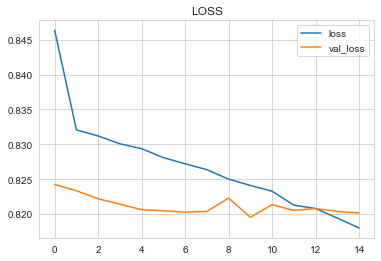

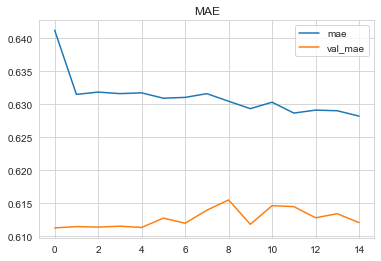

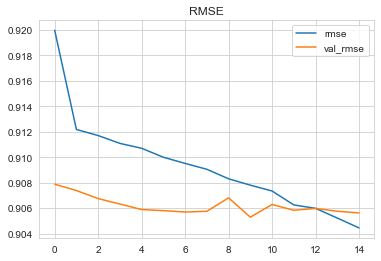

<IPython.core.display.Javascript object>

In [26]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_1.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

##### Model evaluation

In [42]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_1"
[loss_test, mse_test, mae_test, rmse_test] = model_conv1D.evaluate(X_test_reshaped, y_test, verbose=1)

534/534 [==============================] - 2s 3ms/step - loss: 0.8050 - mse: 0.8050 - mae: 0.5946 - rmse: 0.8972


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
# Get pearson score
pearson_score = pearsonr(model_conv1D.predict(X_test_reshaped).reshape(-1), y_test)[0]
pearson_score

0.09422102715881768

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
# put results in a dataframe
df_test_1 = pd.DataFrame(
    [[model, 
      loss_test, 
      mse_test, 
      mae_test, 
      rmse_test, 
      pearson_score]], 
    columns = ["model", 
               "loss_test", 
               "mse_test",
               "mae_test", 
               "rmse_test",
               "pearson_score" ])

df_test_1.insert(loc=1, column="epochs", value=len(hist_df_1))
df_test_1

,model,epochs,loss_test,mse_test,mae_test,rmse_test,pearson_score
0,Conv1D_1,15,0.805046,0.805046,0.594623,0.897243,0.094221


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's go further in training.

In [49]:
def build_conv1D_model(train_data_reshaped):
    
    """
    Function to create neuronal networks with conv1D
    
    Arguments :
    - train_data_reshaped : training data with correct shape.
    
    Return :
    - model : compiled model with all layers.
    """
    
    n_timesteps = train_data_reshaped.shape[1]  
    n_features = train_data_reshaped.shape[2]  
    
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps, n_features)))
    
    # Convolution 1
    model.add(
        keras.layers.Conv1D(
            filters=64, kernel_size=7, activation="relu", name="Conv1D_1"
        )
    )
    
    # Dropout
    model.add(keras.layers.Dropout(0.5))
    
    # Convolution 2
    model.add(
        keras.layers.Conv1D(
            filters=32, kernel_size=3, activation="relu", name="Conv1D_2"
        )
    )
    
    # Convolution 3
    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=2, activation="relu", name="Conv1D_3"
        )
    )
    
    # MaxPooling
    model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    
    # Flatten
    model.add(keras.layers.Flatten())
    
    # Dense layers
    model.add(keras.layers.Dense(32, activation="relu", name="Dense_1"))
    model.add(keras.layers.Dense(n_features, name="Dense_2"))
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(0.001)
    
    # RMSE
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    
    # Model compilation
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmse])
    
    return model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
# Create model and display summary
model_conv1D = build_conv1D_model(X_train_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 294, 64)           512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 294, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 292, 32)           6176      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 291, 16)           1040      
_________________________________________________________________
MaxPooling1D (MaxPooling1D)  (None, 145, 16)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2320)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)               

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Checkpoint and earlystop

In [52]:
# File to save model
model_file_name = "./Models/Conv1D_1_1.tf"

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file_name, 
                                             monitor="val_rmse", 
                                             mode="min", 
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose = 1)

early_stop = keras.callbacks.EarlyStopping(monitor="val_rmse", 
                                           patience=10, 
                                           verbose = 1, 
                                           restore_best_weights = True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Train the model
We train the model for 50 epochs.

In [53]:
%%time

EPOCHS=50
BATCH_SIZE = 4096

history_1_1 = model_conv1D.fit(x=X_train_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/50
28/28 [==============================] - 59s 2s/step - loss: 0.8432 - mae: 0.6385 - rmse: 0.9183 - val_loss: 0.8244 - val_mae: 0.6119 - val_rmse: 0.9080

Epoch 00001: val_rmse improved from inf to 0.90798, saving model to ./Models/Conv1D_1_1.tf
Epoch 2/50
28/28 [==============================] - 55s 2s/step - loss: 0.8323 - mae: 0.6314 - rmse: 0.9123 - val_loss: 0.8234 - val_mae: 0.6116 - val_rmse: 0.9074

Epoch 00002: val_rmse improved from 0.90798 to 0.90741, saving model to ./Models/Conv1D_1_1.tf
Epoch 3/50
28/28 [==============================] - 58s 2s/step - loss: 0.8311 - mae: 0.6319 - rmse: 0.9117 - val_loss: 0.8219 - val_mae: 0.6117 - val_rmse: 0.9066

Epoch 00003: val_rmse improved from 0.90741 to 0.90659, saving model to ./Models/Conv1D_1_1.tf
Epoch 4/50
28/28 [==============================] - 55s 2s/step - loss: 0.8285 - mae: 0.6312 - rmse: 0.9102 - val_loss: 0.8211 - val_mae: 0.6133 - val_rmse: 0.9062

Epoch 00004: val_rmse improved from 0.90659 to 0.90616, sav

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
# Convert the history.history dict to a pandas DataFrame 
hist_df_1_1 = pd.DataFrame(history_1_1.history) 

# Save to csv
hist_1_1_csv_file = "./Models/history_1_1.csv"
with open(hist_1_1_csv_file, mode='w') as f:
    hist_df_1_1.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

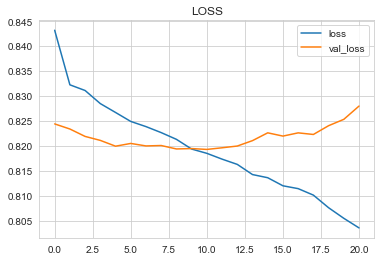

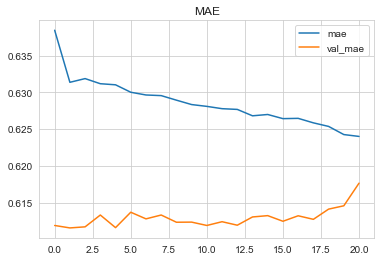

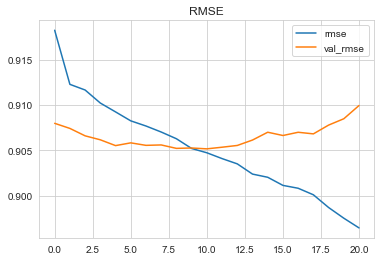

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_1_1.history, 
                 columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

##### Model evaluation

In [56]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_1_1"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(X_test_reshaped, y_test, verbose=1)

534/534 [==============================] - 2s 3ms/step - loss: 0.8069 - mae: 0.5966 - rmse: 0.8982


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
# Get pearson score
pearson_score = pearsonr(
    model_conv1D.predict(X_test_reshaped).reshape(-1), 
    y_test)[0]

# Results in dataframe
df_test_1_1 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]], 
    columns = [
        "model", 
        "loss_test", 
        "mae_test", 
        "rmse_test",
        "pearson_score"
    ]
)
df_test_1_1.insert(loc=1, 
                   column="epochs", 
                   value=len(hist_df_1_1))
df_test_1_1

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_1_1,21,0.806851,0.596615,0.898249,0.084132


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Results are worse with a longer training.

In [64]:
# Concatenate with previous model
df_test_conv = pd.concat([df_test_1, df_test_1_1], axis=0).reset_index(drop=True)
df_test_conv.drop(["mse_test"], axis=1, inplace=True)
# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's see how model perform on X_scaled.

In [13]:
# Reshape X_scaled
X_scaled_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Scaled X_test
X_test_scaled = robust_scal.transform(X_test)
X_test_sc_reshaped = X_test_scaled.reshape(
    X_test_scaled.shape[0], X_test_scaled.shape[1], 1
)

<IPython.core.display.Javascript object>

In [67]:
# Create model and display summary
model_conv1D = build_conv1D_model(X_scaled_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 294, 64)           512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 294, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 292, 32)           6176      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 291, 16)           1040      
_________________________________________________________________
MaxPooling1D (MaxPooling1D)  (None, 145, 16)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2320)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)               

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Checkpoint and earlystop

In [68]:
# File to save model
model_file_name = "./Models/Conv1D_scal_1.tf"

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file_name, 
                                             monitor="val_rmse", 
                                             mode="min", 
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose = 1)

early_stop = keras.callbacks.EarlyStopping(monitor="val_rmse", 
                                           patience=5, 
                                           verbose = 1, 
                                           restore_best_weights = True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Train the model

In [69]:
%%time

EPOCHS=50
BATCH_SIZE = 4096

history_scal_1 = model_conv1D.fit(x=X_scaled_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/50
28/28 [==============================] - 60s 2s/step - loss: 0.9454 - mae: 0.6710 - rmse: 0.9723 - val_loss: 0.8234 - val_mae: 0.6120 - val_rmse: 0.9074

Epoch 00001: val_rmse improved from inf to 0.90739, saving model to ./Models/Conv1D_scal_1.tf
Epoch 2/50
28/28 [==============================] - 57s 2s/step - loss: 0.8376 - mae: 0.6362 - rmse: 0.9152 - val_loss: 0.8239 - val_mae: 0.6124 - val_rmse: 0.9077

Epoch 00002: val_rmse did not improve from 0.90739
Epoch 3/50
28/28 [==============================] - 57s 2s/step - loss: 0.8338 - mae: 0.6347 - rmse: 0.9131 - val_loss: 0.8227 - val_mae: 0.6114 - val_rmse: 0.9070

Epoch 00003: val_rmse improved from 0.90739 to 0.90704, saving model to ./Models/Conv1D_scal_1.tf
Epoch 4/50
28/28 [==============================] - 53s 2s/step - loss: 0.8327 - mae: 0.6336 - rmse: 0.9125 - val_loss: 0.8220 - val_mae: 0.6109 - val_rmse: 0.9066

Epoch 00004: val_rmse improved from 0.90704 to 0.90665, saving model to ./Models/Conv1D_scal_1.tf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
# Convert the history.history dict to a pandas DataFrame 
hist_df_scal_1 = pd.DataFrame(history_scal_1.history) 

# Save to csv
hist_scal_1_csv_file = "./Models/history_scal_1.csv"
with open(hist_scal_1_csv_file, mode='w') as f:
    hist_df_scal_1.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

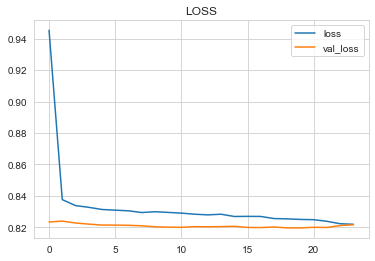

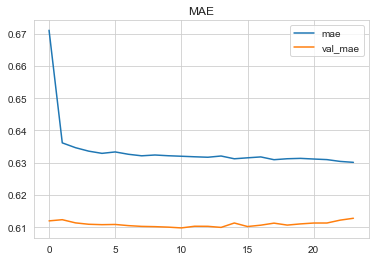

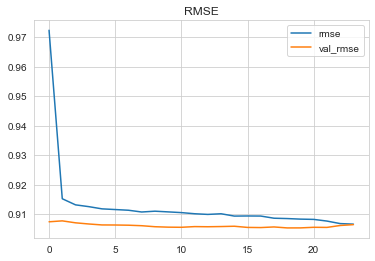

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_scal_1.history, 
                 columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

##### Model Evaluation

In [72]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_scal_1"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(X_test_sc_reshaped, y_test, verbose=1)

534/534 [==============================] - 2s 4ms/step - loss: 0.8061 - mae: 0.5941 - rmse: 0.8978


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
# Get pearson score
pearson_score = pearsonr(
    model_conv1D.predict(X_test_sc_reshaped).reshape(-1), 
    y_test)[0]

# Results in dataframe
df_test_scal_1 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]], 
    columns = [
        "model", 
        "loss_test", 
        "mae_test", 
        "rmse_test",
        "pearson_score"
    ]
)
df_test_scal_1.insert(loc=1, 
                   column="epochs", 
                   value=len(hist_df_scal_1))
df_test_scal_1

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_scal_1,24,0.806059,0.594119,0.897808,0.084341


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
# Concatenate results
df_test_conv = pd.concat([df_test_conv, df_test_scal_1], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's try on X_pca85.

In [75]:
# Reshape X_pca85
X_pca85_reshaped = X_pca85.reshape(X_pca85.shape[0], X_pca85.shape[1], 1)

# PCA X_test
X_pca85_test = pca_85.transform(X_test)
X_pca85_test_reshaped = X_pca85_test.reshape(
    X_pca85_test.shape[0], X_pca85_test.shape[1], 1
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
# Create model and display summary
model_conv1D = build_conv1D_model(X_pca85_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 119, 64)           512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 119, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 117, 32)           6176      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 116, 16)           1040      
_________________________________________________________________
MaxPooling1D (MaxPooling1D)  (None, 58, 16)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 928)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)               

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Checkpoint and earlystop

In [77]:
# File to save model
model_file_name = "./Models/Conv1D_pca_1.tf"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_rmse",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=5, verbose=1, restore_best_weights=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Train the model

In [79]:
%%time

EPOCHS=50
BATCH_SIZE = 4096

history_pca_1 = model_conv1D.fit(x=X_pca85_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/50
28/28 [==============================] - 21s 730ms/step - loss: 0.8312 - mae: 0.6306 - rmse: 0.9117 - val_loss: 0.8232 - val_mae: 0.6123 - val_rmse: 0.9073

Epoch 00001: val_rmse improved from 0.90778 to 0.90732, saving model to ./Models/Conv1D_pca_1.tf
Epoch 2/50
28/28 [==============================] - 21s 743ms/step - loss: 0.8310 - mae: 0.6319 - rmse: 0.9116 - val_loss: 0.8228 - val_mae: 0.6133 - val_rmse: 0.9071

Epoch 00002: val_rmse improved from 0.90732 to 0.90709, saving model to ./Models/Conv1D_pca_1.tf
Epoch 3/50
28/28 [==============================] - 21s 746ms/step - loss: 0.8299 - mae: 0.6321 - rmse: 0.9110 - val_loss: 0.8217 - val_mae: 0.6125 - val_rmse: 0.9065

Epoch 00003: val_rmse improved from 0.90709 to 0.90646, saving model to ./Models/Conv1D_pca_1.tf
Epoch 4/50
28/28 [==============================] - 22s 780ms/step - loss: 0.8290 - mae: 0.6320 - rmse: 0.9105 - val_loss: 0.8214 - val_mae: 0.6134 - val_rmse: 0.9063

Epoch 00004: val_rmse improved from 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
# Convert the history.history dict to a pandas DataFrame 
hist_df_pca_1 = pd.DataFrame(history_pca_1.history) 

# Save to csv
hist_pca_1_csv_file = "./Models/history_pca_1.csv"
with open(hist_pca_1_csv_file, mode='w') as f:
    hist_df_pca_1.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

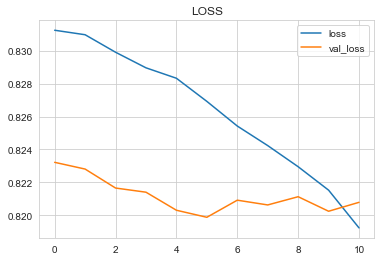

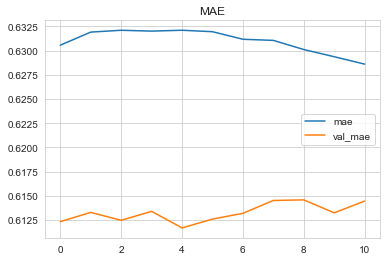

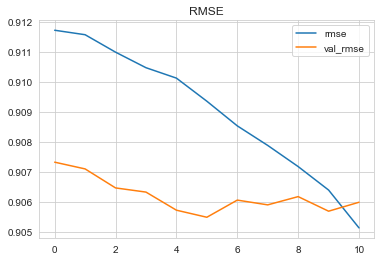

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [81]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_pca_1.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

##### Model evaluation

In [82]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_pca_1"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(X_pca85_test_reshaped, y_test, verbose=1)

534/534 [==============================] - 1s 2ms/step - loss: 0.8071 - mae: 0.5960 - rmse: 0.8984


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [83]:
# Get pearson score
pearson_score = pearsonr(
    model_conv1D.predict(X_pca85_test_reshaped).reshape(-1), 
    y_test)[0]

# Results in a dataframe
df_test_pca_1 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]], 
    columns = [
        "model", 
        "loss_test", 
        "mae_test", 
        "rmse_test",
        "pearson_score"
    ]
)
df_test_pca_1.insert(loc=1, 
                   column="epochs", 
                   value=len(hist_df_pca_1))
df_test_pca_1

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_pca_1,11,0.807132,0.596023,0.898405,0.074178


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
# Concatenate the results
df_test_conv = pd.concat([df_test_conv, df_test_pca_1], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### CNN2
So let's change our model, especially regarding activation (considering this kernel https://www.kaggle.com/code/lonnieqin/ubiquant-market-prediction-with-dnn/notebook).

In [97]:
def build_conv1D_model_2(train_data_reshaped):
    
    """
    Function to create neuronal networks with conv1D
    
    Arguments :
    - train_data_reshaped : training data with correct shape.
    
    Return :
    - model : compiled model with all layers.
    """
    
    n_timesteps = train_data_reshaped.shape[1]  
    n_features = train_data_reshaped.shape[2]  
    
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps, n_features)))
    
    # Convolution 1 with LeakyReLU
    model.add(keras.layers.Conv1D(filters=64, kernel_size=7, name="Conv1D_1"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_1"))
    
    # Dropout
    model.add(keras.layers.Dropout(0.5))
    
    # Convolution 2 with LeakyReLU
    model.add(keras.layers.Conv1D(filters=32, kernel_size=3, name="Conv1D_2"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_2"))
    
    # Convolution 3 with LeakyReLU
    model.add(keras.layers.Conv1D(filters=16, kernel_size=2, name="Conv1D_3"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_3"))
    
    # MaxPooling
    model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    
    # Flatten
    model.add(keras.layers.Flatten())
    
    # Dense layers
    model.add(keras.layers.Dense(32, activation="swish", name="Dense_1"))
    model.add(keras.layers.Dense(n_features, name="Dense_2"))
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(0.001)
    
    # RMSE
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    
    # Model compilation
    model.compile(loss="mse", optimizer=optimizer, metrics=["mse", "mae", rmse])
    
    return model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
# Create model and display summary
model_conv1D = build_conv1D_model_2(X_train_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 294, 64)           512       
_________________________________________________________________
LeakyReLU_1 (LeakyReLU)      (None, 294, 64)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 294, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 292, 32)           6176      
_________________________________________________________________
LeakyReLU_2 (LeakyReLU)      (None, 292, 32)           0         
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 291, 16)           1040      
_________________________________________________________________
LeakyReLU_3 (LeakyReLU)      (None, 291, 16)          

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Checkpoint and earlystop

In [99]:
# File to save model
model_file_name = "./Models/Conv1D_2.tf"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_rmse",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=5, verbose=1, restore_best_weights=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Train the model

In [100]:
%%time

EPOCHS=50
BATCH_SIZE = 4096

history_2 = model_conv1D.fit(x=X_train_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/50
28/28 [==============================] - 60s 2s/step - loss: 0.8809 - mse: 0.8809 - mae: 0.6591 - rmse: 0.9386 - val_loss: 0.8244 - val_mse: 0.8244 - val_mae: 0.6187 - val_rmse: 0.9079

Epoch 00001: val_rmse improved from inf to 0.90794, saving model to ./Models/Conv1D_2.tf
Epoch 2/50
28/28 [==============================] - 54s 2s/step - loss: 0.8297 - mse: 0.8297 - mae: 0.6304 - rmse: 0.9109 - val_loss: 0.8241 - val_mse: 0.8241 - val_mae: 0.6200 - val_rmse: 0.9078

Epoch 00002: val_rmse improved from 0.90794 to 0.90781, saving model to ./Models/Conv1D_2.tf
Epoch 3/50
28/28 [==============================] - 56s 2s/step - loss: 0.8276 - mse: 0.8276 - mae: 0.6311 - rmse: 0.9097 - val_loss: 0.8207 - val_mse: 0.8207 - val_mae: 0.6153 - val_rmse: 0.9059

Epoch 00003: val_rmse improved from 0.90781 to 0.90594, saving model to ./Models/Conv1D_2.tf
Epoch 4/50
28/28 [==============================] - 57s 2s/step - loss: 0.8260 - mse: 0.8260 - mae: 0.6312 - rmse: 0.9088 - val_loss: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [101]:
# Convert the history.history dict to a pandas DataFrame 
hist_df_2 = pd.DataFrame(history_2.history) 

# Save to csv
hist_2_csv_file = "./Models/history_2.csv"
with open(hist_2_csv_file, mode='w') as f:
    hist_df_2.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

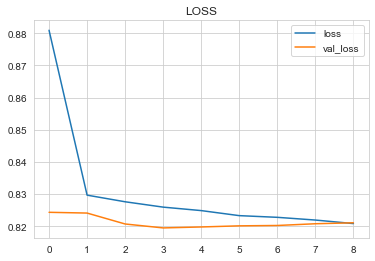

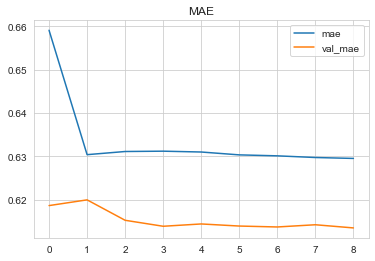

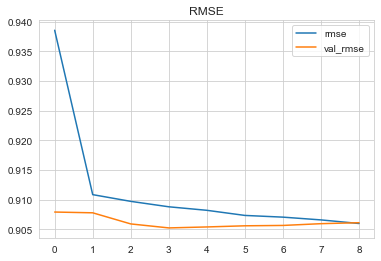

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [102]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_2.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

##### Model evaluation

In [104]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_2"
[loss_test, mse_test, mae_test, rmse_test] = model_conv1D.evaluate(
    X_test_reshaped, y_test, verbose=1
)

534/534 [==============================] - 2s 3ms/step - loss: 0.8063 - mse: 0.8063 - mae: 0.5976 - rmse: 0.8979


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [105]:
# Get Pearson score
pearson_score = pearsonr(
    model_conv1D.predict(X_test_reshaped).reshape(-1), 
    y_test)[0]

# Results in a dataframe
df_test_2 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]], 
    columns = [
        "model", 
        "loss_test", 
        "mae_test", 
        "rmse_test",
        "pearson_score"
    ]
)
df_test_2.insert(loc=1, 
                   column="epochs", 
                   value=len(hist_df_2))
df_test_2

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_2,9,0.806295,0.597559,0.897939,0.085613


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [106]:
# Concatenate results
df_test_conv = pd.concat([df_test_conv, df_test_2], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### CNN3
Let's try this kind of model but with less DenseLayers :
https://www.kaggle.com/code/ghostcxs/prediction-including-spatial-info-with-conv1d

In [191]:
def build_conv1D_model_3(train_data_reshaped):
    
    """
    Function to create neuronal networks with conv1D
    
    Arguments :
    - train_data_reshaped : training data with correct shape.
    
    Return :
    - model : compiled model with all layers.
    """
    
    n_timesteps = train_data_reshaped.shape[1]  
    n_features = train_data_reshaped.shape[2] 
    
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps, n_features)))

    # Convolution 1 with LeakyReLu
    model.add(
        keras.layers.Conv1D(
            filters=64, kernel_size=4, strides=1, padding="same", name="Conv1D_1"
        )
    )
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_1"))
    
    # Dropout
    model.add(keras.layers.Dropout(0.5))
    
    # Convolution 2 with LeakyReLU
    model.add(
        keras.layers.Conv1D(filters=16, kernel_size=8, strides=3, name="Conv1D_2")
    )
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_2"))

    # Convolution 3 with LeakyReLU
    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=3, strides=1, name="Conv1D_3"
        )
    )
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_3"))

    # Convolution 4
    model.add(
        keras.layers.Conv1D(
            filters=32, kernel_size=4, strides=3,  padding="same",name="Conv1D_4"
        )
    )
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_4"))

    # Convolution 5
    model.add(
        keras.layers.Conv1D(
            filters=64, kernel_size=4, strides=4, padding="same", name="Conv1D_5"
        )
    )
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_5"))

    # Flatten 
    model.add(keras.layers.Flatten())
    
    # Dense layers
    model.add(keras.layers.Dense(64, activation="swish", name="Dense_2"))
    model.add(keras.layers.Dense(32, activation="swish", name="Dense_3"))
    model.add(keras.layers.Dense(n_features, name="Dense_4"))
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(0.001)
    
    # RMSE
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    
    # Model compilation
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmse])
    
    return model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [192]:
# Create model and display summary
model_conv1D = build_conv1D_model_3(X_train_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 300, 64)           320       
_________________________________________________________________
LeakyReLU_1 (LeakyReLU)      (None, 300, 64)           0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 300, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 98, 16)            8208      
_________________________________________________________________
LeakyReLU_2 (LeakyReLU)      (None, 98, 16)            0         
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 96, 16)            784       
_________________________________________________________________
LeakyReLU_3 (LeakyReLU)      (None, 96, 16)           

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Checkpoint and earlystop

In [193]:
# File to save model
model_file_name = "./Models/Conv1D_3.tf"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_rmse",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=5, verbose=1, restore_best_weights=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Train the model

In [194]:
%%time

EPOCHS=30
BATCH_SIZE = 4096

history_3 = model_conv1D.fit(x=X_train_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/30
28/28 [==============================] - 48s 2s/step - loss: 0.8289 - mae: 0.6316 - rmse: 0.9105 - val_loss: 0.8198 - val_mae: 0.6122 - val_rmse: 0.9054

Epoch 00001: val_rmse improved from inf to 0.90543, saving model to ./Models/Conv1D_3.tf
Epoch 2/30
28/28 [==============================] - 46s 2s/step - loss: 0.8254 - mae: 0.6308 - rmse: 0.9085 - val_loss: 0.8190 - val_mae: 0.6120 - val_rmse: 0.9050

Epoch 00002: val_rmse improved from 0.90543 to 0.90496, saving model to ./Models/Conv1D_3.tf
Epoch 3/30
28/28 [==============================] - 46s 2s/step - loss: 0.8226 - mae: 0.6295 - rmse: 0.9070 - val_loss: 0.8189 - val_mae: 0.6119 - val_rmse: 0.9049

Epoch 00003: val_rmse improved from 0.90496 to 0.90490, saving model to ./Models/Conv1D_3.tf
Epoch 4/30
28/28 [==============================] - 46s 2s/step - loss: 0.8199 - mae: 0.6289 - rmse: 0.9055 - val_loss: 0.8192 - val_mae: 0.6117 - val_rmse: 0.9051

Epoch 00004: val_rmse did not improve from 0.90490
Epoch 5/30
28/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [198]:
# Convert the history.history dict to a pandas DataFrame
hist_df_3 = pd.DataFrame(history_3.history)

# Save to csv
hist_3_csv_file = "./Models/history_3.csv"
with open(hist_3_csv_file, mode="w") as f:
    hist_df_3.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

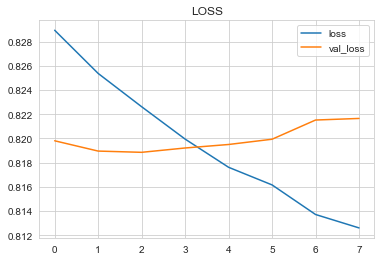

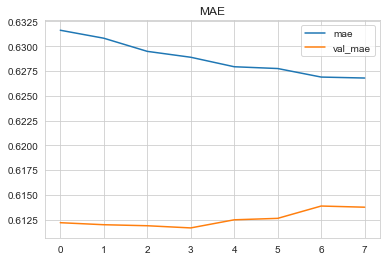

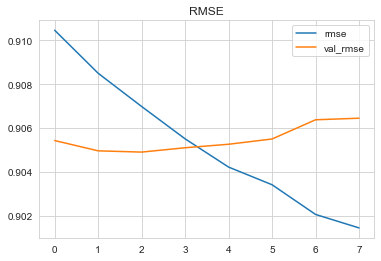

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [195]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_3.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

##### Model evaluation

In [196]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_3"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(
    X_test_reshaped, y_test, verbose=1
)

534/534 [==============================] - 1s 3ms/step - loss: 0.8051 - mae: 0.5956 - rmse: 0.8973


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [201]:
# Get pearson score
pearson_score = pearsonr(model_conv1D.predict(X_test_reshaped).reshape(-1), y_test)[0]

# Results in dataframe
df_test_3 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]],
    columns=["model", "loss_test", "mae_test", "rmse_test", "pearson_score"],
)
df_test_3.insert(loc=1, column="epochs", value=len(hist_df_3))
df_test_3

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_3,8,0.805138,0.595649,0.897295,0.089078


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [202]:
# Concatenate results
df_test_conv = pd.concat([df_test_conv, df_test_3], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [206]:
df_test_conv

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_1,15,0.805046,0.594623,0.897243,0.094221
1,Conv1D_1_1,21,0.806851,0.596615,0.898249,0.084132
2,Conv1D_scal_1,24,0.806059,0.594119,0.897808,0.084341
3,Conv1D_pca_1,11,0.807132,0.596023,0.898405,0.074178
4,Conv1D_2,9,0.806295,0.597559,0.897939,0.085613
6,Conv1D_3,8,0.805138,0.595649,0.897295,0.089078


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### CNN4
Let's adding in dense layers a kernel_regularizer.

In [207]:
def build_conv1D_model_4(train_data_reshaped):
    
    """
    Function to create neuronal networks with conv1D
    
    Arguments :
    - train_data_reshaped : training data with correct shape.
    
    Return :
    - model : compiled model with all layers.
    """
    
    n_timesteps = train_data_reshaped.shape[1]  
    n_features = train_data_reshaped.shape[2] 
    
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps, n_features)))

    # Convolution 1 with LeakyReLU
    model.add(
        keras.layers.Conv1D(
            filters=64, kernel_size=4, strides=1, padding="same", name="Conv1D_1"
        )
    )
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_1"))
    
    # Dropout
    model.add(keras.layers.Dropout(0.5))
    
    # Convolution 2 with LeakyReLU
    model.add(
        keras.layers.Conv1D(filters=16, kernel_size=8, strides=3, name="Conv1D_2")
    )
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_2"))

    # Convolution 3 with LeakyReLU
    model.add(
        keras.layers.Conv1D(filters=16, kernel_size=3, strides=1, name="Conv1D_3")
    )
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_3"))

    # Convolution 4 with LeakyReLU
    model.add(
        keras.layers.Conv1D(
            filters=32, kernel_size=4, strides=3, padding="same", name="Conv1D_4"
        )
    )
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_4"))

    # Convolution 5 with LeakyReLU
    model.add(
        keras.layers.Conv1D(
            filters=64, kernel_size=4, strides=4, padding="same", name="Conv1D_5"
        )
    )
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_5"))

    # Flatten 
    model.add(keras.layers.Flatten())
    
    # Dense layers
    model.add(
        keras.layers.Dense(
            64, activation="swish", name="Dense_2", kernel_regularizer="l2"
        )
    )
    model.add(
        keras.layers.Dense(
            32, activation="swish", name="Dense_3", kernel_regularizer="l2"
        )
    )
    model.add(keras.layers.Dense(n_features, name="Dense_4"))
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(0.001)
    
    # RMSE
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    
    # Model compilation
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmse])
    
    return model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [208]:
# Create model and display summary
model_conv1D = build_conv1D_model_4(X_train_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 300, 64)           320       
_________________________________________________________________
LeakyReLU_1 (LeakyReLU)      (None, 300, 64)           0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 300, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 98, 16)            8208      
_________________________________________________________________
LeakyReLU_2 (LeakyReLU)      (None, 98, 16)            0         
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 96, 16)            784       
_________________________________________________________________
LeakyReLU_3 (LeakyReLU)      (None, 96, 16)           

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Checkpoint and earlystop

In [209]:
# File to save model
model_file_name = "./Models/Conv1D_4.tf"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_rmse",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=5, verbose=1, restore_best_weights=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Train the model

In [210]:
%%time

EPOCHS=30
BATCH_SIZE = 4096

history_4 = model_conv1D.fit(x=X_train_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/30
28/28 [==============================] - 49s 2s/step - loss: 1.9643 - mae: 0.6320 - rmse: 0.9112 - val_loss: 1.5733 - val_mae: 0.6122 - val_rmse: 0.9059

Epoch 00001: val_rmse improved from inf to 0.90585, saving model to ./Models/Conv1D_4.tf
Epoch 2/30
28/28 [==============================] - 48s 2s/step - loss: 1.3712 - mae: 0.6306 - rmse: 0.9090 - val_loss: 1.1846 - val_mae: 0.6112 - val_rmse: 0.9049

Epoch 00002: val_rmse improved from 0.90585 to 0.90488, saving model to ./Models/Conv1D_4.tf
Epoch 3/30
28/28 [==============================] - 47s 2s/step - loss: 1.0972 - mae: 0.6299 - rmse: 0.9080 - val_loss: 1.0109 - val_mae: 0.6113 - val_rmse: 0.9047

Epoch 00003: val_rmse improved from 0.90488 to 0.90472, saving model to ./Models/Conv1D_4.tf
Epoch 4/30
28/28 [==============================] - 48s 2s/step - loss: 0.9727 - mae: 0.6295 - rmse: 0.9072 - val_loss: 0.9302 - val_mae: 0.6110 - val_rmse: 0.9047

Epoch 00004: val_rmse improved from 0.90472 to 0.90470, saving mo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [211]:
# Convert the history.history dict to a pandas DataFrame
hist_df_4 = pd.DataFrame(history_4.history)

# Save to csv
hist_4_csv_file = "./Models/history_4.csv"
with open(hist_4_csv_file, mode="w") as f:
    hist_df_4.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

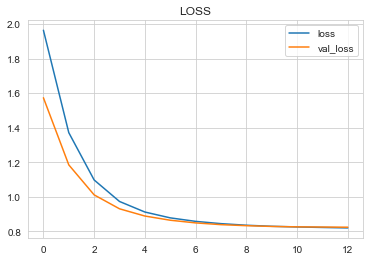

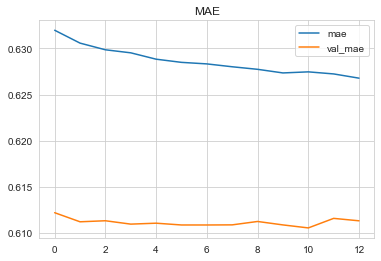

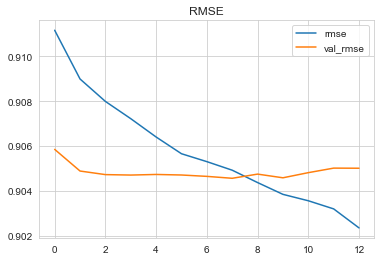

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [212]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_4.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

##### Model evaluation

In [213]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_4"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(
    X_test_reshaped, y_test, verbose=1
)

534/534 [==============================] - 1s 2ms/step - loss: 0.8253 - mae: 0.5956 - rmse: 0.8972


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [214]:
# Get pearson score
pearson_score = pearsonr(model_conv1D.predict(X_test_reshaped).reshape(-1), y_test)[0]

# Results in dataframe
df_test_4 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]],
    columns=["model", "loss_test", "mae_test", "rmse_test", "pearson_score"],
)
df_test_4.insert(loc=1, column="epochs", value=len(hist_df_3))
df_test_4

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_4,8,0.82527,0.595556,0.89725,0.08966


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [215]:
# Concatenate results
df_test_conv = pd.concat([df_test_conv, df_test_4], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [216]:
df_test_conv

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_1,15,0.805046,0.594623,0.897243,0.094221
1,Conv1D_1_1,21,0.806851,0.596615,0.898249,0.084132
2,Conv1D_scal_1,24,0.806059,0.594119,0.897808,0.084341
3,Conv1D_pca_1,11,0.807132,0.596023,0.898405,0.074178
4,Conv1D_2,9,0.806295,0.597559,0.897939,0.085613
5,Conv1D_3,8,0.805138,0.595649,0.897295,0.089078
6,Conv1D_4,8,0.825270,0.595556,0.897250,0.089660


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [228]:
df_test_conv.iloc[6, 1] = len(hist_df_4)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### CNN5
Let's see what is happening if we change LeakyReLu to ReLU.

In [217]:
def build_conv1D_model_5(train_data_reshaped):
    
    """
    Function to create neuronal networks with conv1D
    
    Arguments :
    - train_data_reshaped : training data with correct shape.
    
    Return :
    - model : compiled model with all layers.
    """
    
    n_timesteps = train_data_reshaped.shape[1]  
    n_features = train_data_reshaped.shape[2]  
    
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps, n_features)))

    # Convolution 1
    model.add(
        keras.layers.Conv1D(
            filters=64,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="relu",
            name="Conv1D_1",
        )
    )
    model.add(keras.layers.Dropout(0.5))

    # Convolution 2
    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=8, strides=3, activation="relu", name="Conv1D_2"
        )
    )

    # Convolution 3
    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=3, strides=1, activation="relu", name="Conv1D_3"
        )
    )

    # Convolution 4
    model.add(
        keras.layers.Conv1D(
            filters=32,
            kernel_size=4,
            strides=3,
            padding="same",
            activation="relu",
            name="Conv1D_4",
        )
    )

    # Convolution 5
    model.add(
        keras.layers.Conv1D(
            filters=64,
            kernel_size=4,
            strides=4,
            padding="same",
            activation="relu",
            name="Conv1D_5",
        )
    )

    # Flatten 
    model.add(keras.layers.Flatten())
    
    # Dense layers
    model.add(
        keras.layers.Dense(
            64, activation="relu", name="Dense_2", kernel_regularizer="l2"
        )
    )
    model.add(
        keras.layers.Dense(
            32, activation="relu", name="Dense_3", kernel_regularizer="l2"
        )
    )
    model.add(keras.layers.Dense(n_features, name="Dense_4"))
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(0.001)
    
    # RMSE
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    
    # Model compilation
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmse])
    
    return model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [218]:
# Create model and display summary
model_conv1D = build_conv1D_model_5(X_train_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 300, 64)           320       
_________________________________________________________________
dropout_63 (Dropout)         (None, 300, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 98, 16)            8208      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 96, 16)            784       
_________________________________________________________________
Conv1D_4 (Conv1D)            (None, 32, 32)            2080      
_________________________________________________________________
Conv1D_5 (Conv1D)            (None, 8, 64)             8256      
_________________________________________________________________
flatten_38 (Flatten)         (None, 512)              

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Checkpoint and Earlystop

In [219]:
# File to save model
model_file_name = "./Models/Conv1D_5.tf"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_rmse",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=5, verbose=1, restore_best_weights=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Train the model

In [220]:
%%time

EPOCHS=30
BATCH_SIZE = 4096

history_5 = model_conv1D.fit(x=X_train_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/30
28/28 [==============================] - 59s 2s/step - loss: 1.9687 - mae: 0.6322 - rmse: 0.9121 - val_loss: 1.5787 - val_mae: 0.6133 - val_rmse: 0.9067

Epoch 00001: val_rmse improved from inf to 0.90668, saving model to ./Models/Conv1D_5.tf
Epoch 2/30
28/28 [==============================] - 46s 2s/step - loss: 1.3787 - mae: 0.6320 - rmse: 0.9106 - val_loss: 1.1931 - val_mae: 0.6140 - val_rmse: 0.9066

Epoch 00002: val_rmse improved from 0.90668 to 0.90661, saving model to ./Models/Conv1D_5.tf
Epoch 3/30
28/28 [==============================] - 45s 2s/step - loss: 1.1063 - mae: 0.6316 - rmse: 0.9101 - val_loss: 1.0173 - val_mae: 0.6118 - val_rmse: 0.9055

Epoch 00003: val_rmse improved from 0.90661 to 0.90548, saving model to ./Models/Conv1D_5.tf
Epoch 4/30
28/28 [==============================] - 46s 2s/step - loss: 0.9805 - mae: 0.6309 - rmse: 0.9092 - val_loss: 0.9349 - val_mae: 0.6114 - val_rmse: 0.9053

Epoch 00004: val_rmse improved from 0.90548 to 0.90534, saving mo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [221]:
# Convert the history.history dict to a pandas DataFrame
hist_df_5 = pd.DataFrame(history_5.history)

# Save to csv
hist_5_csv_file = "./Models/history_5.csv"
with open(hist_5_csv_file, mode="w") as f:
    hist_df_5.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

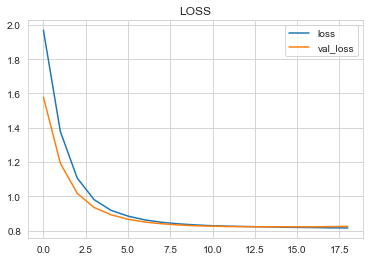

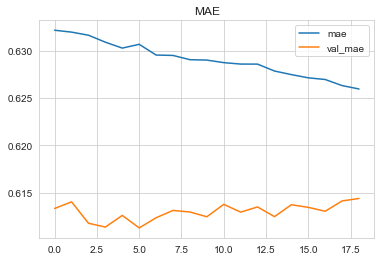

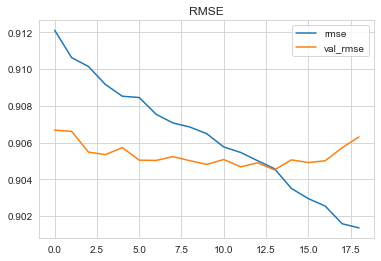

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [222]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_5.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

##### Model Evaluation

In [223]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_5"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(
    X_test_reshaped, y_test, verbose=1
)

534/534 [==============================] - 1s 2ms/step - loss: 0.8116 - mae: 0.5972 - rmse: 0.8987


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [224]:
# Get pearson score
pearson_score = pearsonr(model_conv1D.predict(X_test_reshaped).reshape(-1), y_test)[0]

# Results in a dataframe
df_test_5 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]],
    columns=["model", "loss_test", "mae_test", "rmse_test", "pearson_score"],
)
df_test_5.insert(loc=1, column="epochs", value=len(hist_df_5))
df_test_5

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_5,19,0.811581,0.597225,0.898702,0.079202


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [230]:
# Concatenate results
df_test_conv = pd.concat([df_test_conv, df_test_5], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [231]:
df_test_conv

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_1,15,0.805046,0.594623,0.897243,0.094221
1,Conv1D_1_1,21,0.806851,0.596615,0.898249,0.084132
2,Conv1D_scal_1,24,0.806059,0.594119,0.897808,0.084341
3,Conv1D_pca_1,11,0.807132,0.596023,0.898405,0.074178
4,Conv1D_2,9,0.806295,0.597559,0.897939,0.085613
5,Conv1D_3,8,0.805138,0.595649,0.897295,0.089078
6,Conv1D_4,13,0.825270,0.595556,0.897250,0.089660
7,Conv1D_5,19,0.811581,0.597225,0.898702,0.079202


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### CNN6
We are going to suppress the kernel regularization.

In [12]:
def build_conv1D_model_6(train_data_reshaped):
    
    """
    Function to create neuronal networks with conv1D
    
    Arguments :
    - train_data_reshaped : training data with correct shape.
    
    Return :
    - model : compiled model with all layers.
    """
    
    n_timesteps = train_data_reshaped.shape[1]  
    n_features = train_data_reshaped.shape[2]  
    
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps, n_features)))

    # Convolution 1
    model.add(
        keras.layers.Conv1D(
            filters=64,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="relu",
            name="Conv1D_1",
        )
    )
    
    # Dropout
    model.add(keras.layers.Dropout(0.5))

    # Convolution 2
    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=8, strides=3, activation="relu", name="Conv1D_2"
        )
    )

    # Convolution 3
    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=3, strides=1, activation="relu", name="Conv1D_3"
        )
    )

    # Convolution 4
    model.add(
        keras.layers.Conv1D(
            filters=32,
            kernel_size=4,
            strides=3,
            padding="same",
            activation="relu",
            name="Conv1D_4",
        )
    )

    # Convolution 5
    model.add(
        keras.layers.Conv1D(
            filters=64,
            kernel_size=4,
            strides=4,
            padding="same",
            activation="relu",
            name="Conv1D_5",
        )
    )

    # Flatten 
    model.add(keras.layers.Flatten())
    
    # Dense layers
    model.add(keras.layers.Dense(64, activation="relu", name="Dense_2",))
    model.add(keras.layers.Dense(32, activation="relu", name="Dense_3",))
    model.add(keras.layers.Dense(n_features, name="Dense_4"))
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(0.001)
    
    # RMSE
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    
    # Model compilation
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmse])
    
    return model

<IPython.core.display.Javascript object>

In [233]:
# Create model and display summary
model_conv1D = build_conv1D_model_6(X_train_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 300, 64)           320       
_________________________________________________________________
dropout_64 (Dropout)         (None, 300, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 98, 16)            8208      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 96, 16)            784       
_________________________________________________________________
Conv1D_4 (Conv1D)            (None, 32, 32)            2080      
_________________________________________________________________
Conv1D_5 (Conv1D)            (None, 8, 64)             8256      
_________________________________________________________________
flatten_39 (Flatten)         (None, 512)              

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Checkpoint and Earlystop

In [234]:
# File to save model
model_file_name = "./Models/Conv1D_6.tf"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_rmse",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=5, verbose=1, restore_best_weights=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Train the model

In [235]:
%%time

EPOCHS=30
BATCH_SIZE = 4096

history_6 = model_conv1D.fit(x=X_train_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/30
28/28 [==============================] - 54s 2s/step - loss: 0.8301 - mae: 0.6319 - rmse: 0.9111 - val_loss: 0.8218 - val_mae: 0.6143 - val_rmse: 0.9065

Epoch 00001: val_rmse improved from inf to 0.90654, saving model to ./Models/Conv1D_6.tf
Epoch 2/30
28/28 [==============================] - 53s 2s/step - loss: 0.8269 - mae: 0.6308 - rmse: 0.9093 - val_loss: 0.8215 - val_mae: 0.6139 - val_rmse: 0.9064

Epoch 00002: val_rmse improved from 0.90654 to 0.90637, saving model to ./Models/Conv1D_6.tf
Epoch 3/30
28/28 [==============================] - 55s 2s/step - loss: 0.8245 - mae: 0.6307 - rmse: 0.9080 - val_loss: 0.8199 - val_mae: 0.6136 - val_rmse: 0.9055

Epoch 00003: val_rmse improved from 0.90637 to 0.90550, saving model to ./Models/Conv1D_6.tf
Epoch 4/30
28/28 [==============================] - 46s 2s/step - loss: 0.8226 - mae: 0.6297 - rmse: 0.9070 - val_loss: 0.8188 - val_mae: 0.6118 - val_rmse: 0.9049

Epoch 00004: val_rmse improved from 0.90550 to 0.90488, saving mo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [236]:
# Convert the history.history dict to a pandas DataFrame
hist_df_6 = pd.DataFrame(history_6.history)

# Save to csv
hist_6_csv_file = "./Models/history_6.csv"
with open(hist_6_csv_file, mode="w") as f:
    hist_df_6.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

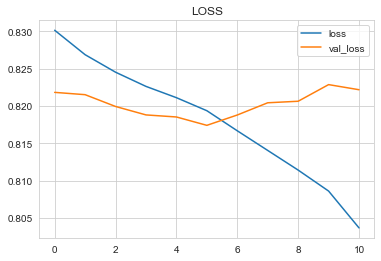

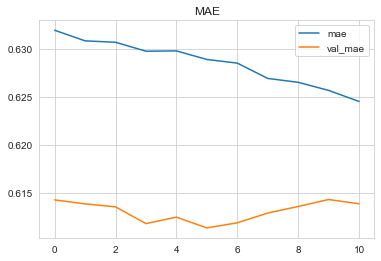

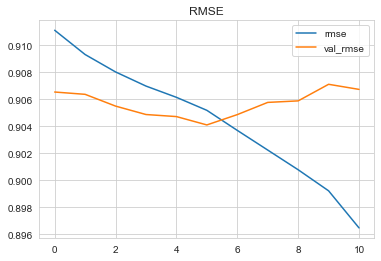

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [237]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_6.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

##### Model evaluation

In [238]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_6"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(
    X_test_reshaped, y_test, verbose=1
)

534/534 [==============================] - 1s 3ms/step - loss: 0.8027 - mae: 0.5948 - rmse: 0.8959


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [239]:
# Get pearson score
pearson_score = pearsonr(model_conv1D.predict(X_test_reshaped).reshape(-1), y_test)[0]

# Results in dataframe
df_test_6 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]],
    columns=["model", "loss_test", "mae_test", "rmse_test", "pearson_score"],
)
df_test_6.insert(loc=1, column="epochs", value=len(hist_df_6))
df_test_6

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_6,11,0.802662,0.5948,0.895914,0.10514


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [240]:
# Concatenate results
df_test_conv = pd.concat([df_test_conv, df_test_6], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [241]:
df_test_conv

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_1,15,0.805046,0.594623,0.897243,0.094221
1,Conv1D_1_1,21,0.806851,0.596615,0.898249,0.084132
2,Conv1D_scal_1,24,0.806059,0.594119,0.897808,0.084341
3,Conv1D_pca_1,11,0.807132,0.596023,0.898405,0.074178
4,Conv1D_2,9,0.806295,0.597559,0.897939,0.085613
5,Conv1D_3,8,0.805138,0.595649,0.897295,0.089078
6,Conv1D_4,13,0.825270,0.595556,0.897250,0.089660
7,Conv1D_5,19,0.811581,0.597225,0.898702,0.079202
8,Conv1D_6,11,0.802662,0.594800,0.895914,0.105140


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [242]:
# Get the best model
df_test_conv_final = df_test_conv.sort_values(by="pearson_score", ascending=False).head(
    1
)
df_test_conv_final

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
8,Conv1D_6,11,0.802662,0.5948,0.895914,0.10514


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [244]:
df_test_conv_final.drop(["epochs", "loss_test", "mae_test"], axis=1, inplace=True)
df_test_conv_final

,model,rmse_test,pearson_score
8,Conv1D_6,0.895914,0.10514


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [246]:
df_test_conv_final.insert(loc=1, column="X_data", value="X_train")
df_test_conv_final.rename(
    columns={"rmse_test": "RMSE", "pearson_score": "Pearson_coef"}, inplace=True
)
df_test_conv_final

,model,X_data,RMSE,Pearson_coef
8,Conv1D_6,X_train,0.895914,0.10514


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [245]:
tf.keras.backend.clear_session()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [248]:
# Load df
df_final = joblib.load("./Data/df_final.joblib")
df_final

,model,X_data,RMSE,Pearson_coef
0,LinearRegression,X_up_pca85,0.897627,0.094731
1,ElasticNet,X_scaled,0.897163,0.098006
2,XGBRegressor,X_scal_pca85,0.898528,0.072302
3,XGBRegressor,X_pca85,0.896879,0.103205


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [249]:
# Add this model to others
df_final = pd.concat([df_final, df_test_conv_final]).reset_index(drop=True)
df_final

,model,X_data,RMSE,Pearson_coef
0,LinearRegression,X_up_pca85,0.897627,0.094731
1,ElasticNet,X_scaled,0.897163,0.098006
2,XGBRegressor,X_scal_pca85,0.898528,0.072302
3,XGBRegressor,X_pca85,0.896879,0.103205
4,Conv1D_6,X_train,0.895914,0.105140


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [250]:
# Save df
joblib.dump(df_final, "./Data/df_final.joblib")

['./Data/df_final.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's try with X_scaled data

In [14]:
# Create model and display summary
model_conv1D = build_conv1D_model_6(X_scaled_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 300, 64)           320       
_________________________________________________________________
dropout (Dropout)            (None, 300, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 98, 16)            8208      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 96, 16)            784       
_________________________________________________________________
Conv1D_4 (Conv1D)            (None, 32, 32)            2080      
_________________________________________________________________
Conv1D_5 (Conv1D)            (None, 8, 64)             8256      
_________________________________________________________________
flatten (Flatten)            (None, 512)              

2022-04-04 09:20:24.230993: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<IPython.core.display.Javascript object>

##### Checkpoint and earlystop

In [15]:
# File to save model
model_file_name = "./Models/Conv1D_6_scal.tf"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_rmse",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=5, verbose=1, restore_best_weights=True
)

<IPython.core.display.Javascript object>

##### Train the model

In [16]:
%%time

EPOCHS=30
BATCH_SIZE = 4096

history_6_sc = model_conv1D.fit(x=X_scaled_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

2022-04-04 09:21:53.414736: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
28/28 [==============================] - 40s 1s/step - loss: 0.8318 - mae: 0.6322 - rmse: 0.9120 - val_loss: 0.8223 - val_mae: 0.6130 - val_rmse: 0.9068

Epoch 00001: val_rmse improved from inf to 0.90682, saving model to ./Models/Conv1D_6_scal.tf
Epoch 2/30
28/28 [==============================] - 38s 1s/step - loss: 0.8304 - mae: 0.6333 - rmse: 0.9112 - val_loss: 0.8224 - val_mae: 0.6121 - val_rmse: 0.9069

Epoch 00002: val_rmse did not improve from 0.90682
Epoch 3/30
28/28 [==============================] - 39s 1s/step - loss: 0.8310 - mae: 0.6332 - rmse: 0.9116 - val_loss: 0.8216 - val_mae: 0.6112 - val_rmse: 0.9064

Epoch 00003: val_rmse improved from 0.90682 to 0.90644, saving model to ./Models/Conv1D_6_scal.tf
Epoch 4/30
28/28 [==============================] - 38s 1s/step - loss: 0.8297 - mae: 0.6328 - rmse: 0.9109 - val_loss: 0.8215 - val_mae: 0.6113 - val_rmse: 0.9063

Epoch 00004: val_rmse improved from 0.90644 to 0.90635, saving model to ./Models/Conv1D_6_scal.tf

<IPython.core.display.Javascript object>

In [17]:
# Convert the history.history dict to a pandas DataFrame
hist_df_6_sc = pd.DataFrame(history_6_sc.history)

# Save to csv
hist_6_sc_csv_file = "./Models/history_6_sc.csv"
with open(hist_6_sc_csv_file, mode="w") as f:
    hist_df_6_sc.to_csv(f)

<IPython.core.display.Javascript object>

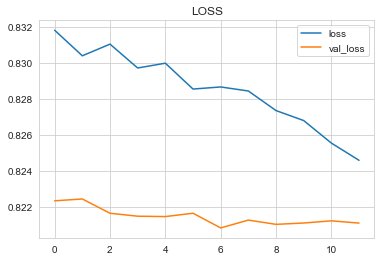

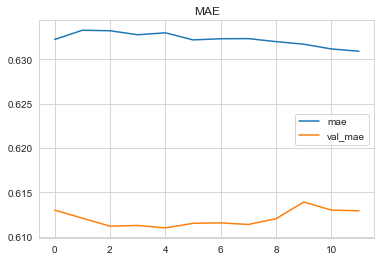

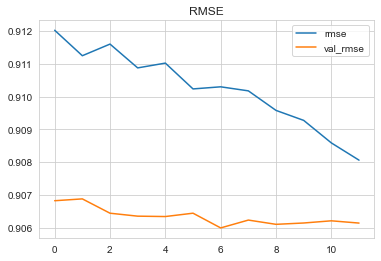

<IPython.core.display.Javascript object>

In [18]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_6_sc.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

##### Model evaluation

In [21]:
# Scaled X_test
X_test_scaled = robust_scal.transform(X_test)
X_test_sc_reshaped = X_test_scaled.reshape(
    X_test_scaled.shape[0], X_test_scaled.shape[1], 1
)

model_conv1D.load_weights(model_file_name)
model = "Conv1D_6_sc"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(
    X_test_sc_reshaped, y_test, verbose=1
)

534/534 [==============================] - 1s 2ms/step - loss: 0.8047 - mae: 0.5938 - rmse: 0.8970


<IPython.core.display.Javascript object>

In [22]:
# Get pearson score
pearson_score = pearsonr(model_conv1D.predict(X_test_sc_reshaped).reshape(-1), y_test)[0]

# Results in dataframe
df_test_6_sc = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]],
    columns=["model", "loss_test", "mae_test", "rmse_test", "pearson_score"],
)
df_test_6_sc.insert(loc=1, column="epochs", value=len(hist_df_6_sc))
df_test_6_sc

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_6_sc,12,0.804695,0.593768,0.897048,0.09957


<IPython.core.display.Javascript object>

In [24]:
df_test_conv = joblib.load("./Data/df_test_conv.joblib")

# Concatenate results
df_test_conv = pd.concat([df_test_conv, df_test_6_sc], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

In [25]:
df_test_conv

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_1,15,0.805046,0.594623,0.897243,0.094221
1,Conv1D_1_1,21,0.806851,0.596615,0.898249,0.084132
2,Conv1D_scal_1,24,0.806059,0.594119,0.897808,0.084341
3,Conv1D_pca_1,11,0.807132,0.596023,0.898405,0.074178
4,Conv1D_2,9,0.806295,0.597559,0.897939,0.085613
5,Conv1D_3,8,0.805138,0.595649,0.897295,0.089078
6,Conv1D_4,13,0.825270,0.595556,0.897250,0.089660
7,Conv1D_5,19,0.811581,0.597225,0.898702,0.079202
8,Conv1D_6,11,0.802662,0.594800,0.895914,0.105140
9,Conv1D_6_sc,12,0.804695,0.593768,0.897048,0.099570


<IPython.core.display.Javascript object>

Let's train longer

In [26]:
# Create model and display summary
model_conv1D = build_conv1D_model_6(X_scaled_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 300, 64)           320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 98, 16)            8208      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 96, 16)            784       
_________________________________________________________________
Conv1D_4 (Conv1D)            (None, 32, 32)            2080      
_________________________________________________________________
Conv1D_5 (Conv1D)            (None, 8, 64)             8256      
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)              

<IPython.core.display.Javascript object>

##### Checkpoint and earlystop

In [27]:
# File to save model
model_file_name = "./Models/Conv1D_6_scal_1.tf"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_rmse",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=10, verbose=1, restore_best_weights=True
)

<IPython.core.display.Javascript object>

##### Train the model

In [28]:
%%time

EPOCHS=30
BATCH_SIZE = 4096

history_6_sc_1 = model_conv1D.fit(x=X_scaled_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/30
28/28 [==============================] - 39s 1s/step - loss: 0.8332 - mae: 0.6328 - rmse: 0.9128 - val_loss: 0.8226 - val_mae: 0.6128 - val_rmse: 0.9070

Epoch 00001: val_rmse improved from inf to 0.90695, saving model to ./Models/Conv1D_6_scal_1.tf
Epoch 2/30
28/28 [==============================] - 38s 1s/step - loss: 0.8299 - mae: 0.6329 - rmse: 0.9110 - val_loss: 0.8218 - val_mae: 0.6119 - val_rmse: 0.9066

Epoch 00002: val_rmse improved from 0.90695 to 0.90656, saving model to ./Models/Conv1D_6_scal_1.tf
Epoch 3/30
28/28 [==============================] - 34s 1s/step - loss: 0.8305 - mae: 0.6332 - rmse: 0.9113 - val_loss: 0.8211 - val_mae: 0.6113 - val_rmse: 0.9061

Epoch 00003: val_rmse improved from 0.90656 to 0.90612, saving model to ./Models/Conv1D_6_scal_1.tf
Epoch 4/30
28/28 [==============================] - 34s 1s/step - loss: 0.8297 - mae: 0.6329 - rmse: 0.9109 - val_loss: 0.8212 - val_mae: 0.6111 - val_rmse: 0.9062

Epoch 00004: val_rmse did not improve from 0

<IPython.core.display.Javascript object>

In [29]:
# Convert the history.history dict to a pandas DataFrame
hist_df_6_sc_1 = pd.DataFrame(history_6_sc_1.history)

# Save to csv
hist_6_sc_1_csv_file = "./Models/history_6_sc_1.csv"
with open(hist_6_sc_1_csv_file, mode="w") as f:
    hist_df_6_sc_1.to_csv(f)

<IPython.core.display.Javascript object>

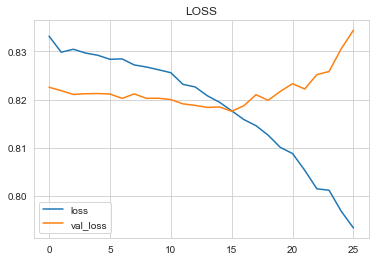

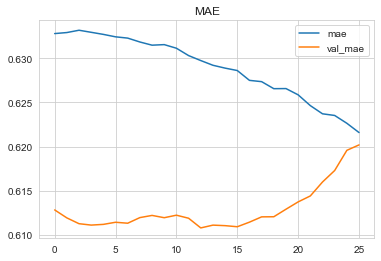

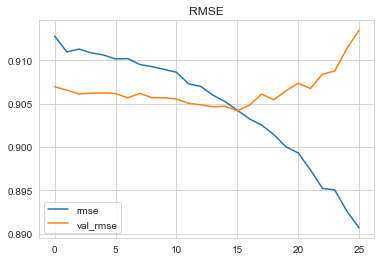

<IPython.core.display.Javascript object>

In [30]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_6_sc_1.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

##### Model Evaluation

In [31]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_6_sc_1"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(
    X_test_sc_reshaped, y_test, verbose=1
)

534/534 [==============================] - 1s 2ms/step - loss: 0.8083 - mae: 0.5954 - rmse: 0.8991


<IPython.core.display.Javascript object>

In [32]:
# Get pearson score
pearson_score = pearsonr(model_conv1D.predict(X_test_sc_reshaped).reshape(-1), y_test)[0]

# Results in datafame
df_test_6_sc_1 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]],
    columns=["model", "loss_test", "mae_test", "rmse_test", "pearson_score"],
)
df_test_6_sc_1.insert(loc=1, column="epochs", value=len(hist_df_6_sc_1))
df_test_6_sc_1

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_6_sc_1,26,0.808319,0.595435,0.899066,0.078823


<IPython.core.display.Javascript object>

In [33]:
# Concatenate results
df_test_conv = pd.concat([df_test_conv, df_test_6_sc_1], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

In [34]:
df_test_conv

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_1,15,0.805046,0.594623,0.897243,0.094221
1,Conv1D_1_1,21,0.806851,0.596615,0.898249,0.084132
2,Conv1D_scal_1,24,0.806059,0.594119,0.897808,0.084341
3,Conv1D_pca_1,11,0.807132,0.596023,0.898405,0.074178
4,Conv1D_2,9,0.806295,0.597559,0.897939,0.085613
5,Conv1D_3,8,0.805138,0.595649,0.897295,0.089078
6,Conv1D_4,13,0.825270,0.595556,0.897250,0.089660
7,Conv1D_5,19,0.811581,0.597225,0.898702,0.079202
8,Conv1D_6,11,0.802662,0.594800,0.895914,0.105140
9,Conv1D_6_sc,12,0.804695,0.593768,0.897048,0.099570


<IPython.core.display.Javascript object>

A longer training is not inscreasing metrics.

#### CNN7
Let's change the learning-rate to 1e-4.

In [43]:
tf.keras.backend.clear_session()

<IPython.core.display.Javascript object>

In [44]:
def build_conv1D_model_7(train_data_reshaped):
    
    """
    Function to create neuronal networks with conv1D
    
    Arguments :
    - train_data_reshaped : training data with correct shape.
    
    Return :
    - model : compiled model with all layers.
    """

    n_timesteps = train_data_reshaped.shape[1]  
    n_features = train_data_reshaped.shape[2]  
    
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps, n_features)))

    # Convolution 1
    model.add(
        keras.layers.Conv1D(
            filters=64,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="relu",
            name="Conv1D_1",
        )
    )
    
    # Dropout
    model.add(keras.layers.Dropout(0.5))

    # Convolution 2
    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=8, strides=3, activation="relu", name="Conv1D_2"
        )
    )

    # Convolution 3
    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=3, strides=1, activation="relu", name="Conv1D_3"
        )
    )

    # Convolution 4
    model.add(
        keras.layers.Conv1D(
            filters=32,
            kernel_size=4,
            strides=3,
            padding="same",
            activation="relu",
            name="Conv1D_4",
        )
    )

    # Convolution 5
    model.add(
        keras.layers.Conv1D(
            filters=64,
            kernel_size=4,
            strides=4,
            padding="same",
            activation="relu",
            name="Conv1D_5",
        )
    )

    # Flatten 
    model.add(keras.layers.Flatten())
    
    # Dense layers
    model.add(keras.layers.Dense(64, activation="relu", name="Dense_2",))
    model.add(keras.layers.Dense(32, activation="relu", name="Dense_3",))
    model.add(keras.layers.Dense(n_features, name="Dense_4"))
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(0.0001)
    
    # RMSE
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")

    # Model compilation
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmse])
    
    return model

<IPython.core.display.Javascript object>

In [47]:
# Create model and display summary
model_conv1D = build_conv1D_model_7(X_train_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 300, 64)           320       
_________________________________________________________________
dropout (Dropout)            (None, 300, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 98, 16)            8208      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 96, 16)            784       
_________________________________________________________________
Conv1D_4 (Conv1D)            (None, 32, 32)            2080      
_________________________________________________________________
Conv1D_5 (Conv1D)            (None, 8, 64)             8256      
_________________________________________________________________
flatten (Flatten)            (None, 512)              

<IPython.core.display.Javascript object>

##### Checkpoint and earlystop

In [48]:
# File to save model
model_file_name = "./Models/Conv1D_7.tf"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_rmse",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=5, verbose=1, restore_best_weights=True
)

<IPython.core.display.Javascript object>

##### Train the model

In [49]:
%%time

EPOCHS=30
BATCH_SIZE = 4096

history_7 = model_conv1D.fit(x=X_train_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/30
28/28 [==============================] - 39s 1s/step - loss: 0.8340 - mae: 0.6349 - rmse: 0.9132 - val_loss: 0.8243 - val_mae: 0.6112 - val_rmse: 0.9079

Epoch 00001: val_rmse improved from inf to 0.90791, saving model to ./Models/Conv1D_7.tf
Epoch 2/30
28/28 [==============================] - 38s 1s/step - loss: 0.8321 - mae: 0.6315 - rmse: 0.9122 - val_loss: 0.8236 - val_mae: 0.6108 - val_rmse: 0.9075

Epoch 00002: val_rmse improved from 0.90791 to 0.90752, saving model to ./Models/Conv1D_7.tf
Epoch 3/30
28/28 [==============================] - 39s 1s/step - loss: 0.8313 - mae: 0.6315 - rmse: 0.9118 - val_loss: 0.8227 - val_mae: 0.6108 - val_rmse: 0.9070

Epoch 00003: val_rmse improved from 0.90752 to 0.90705, saving model to ./Models/Conv1D_7.tf
Epoch 4/30
28/28 [==============================] - 38s 1s/step - loss: 0.8302 - mae: 0.6314 - rmse: 0.9112 - val_loss: 0.8220 - val_mae: 0.6109 - val_rmse: 0.9066

Epoch 00004: val_rmse improved from 0.90705 to 0.90663, saving mo

<IPython.core.display.Javascript object>

In [50]:
# Convert the history.history dict to a pandas DataFrame
hist_df_7 = pd.DataFrame(history_7.history)

# Save to csv
hist_7_csv_file = "./Models/history_7.csv"
with open(hist_7_csv_file, mode="w") as f:
    hist_df_7.to_csv(f)

<IPython.core.display.Javascript object>

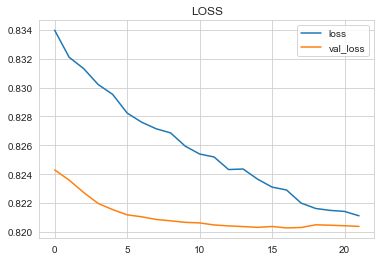

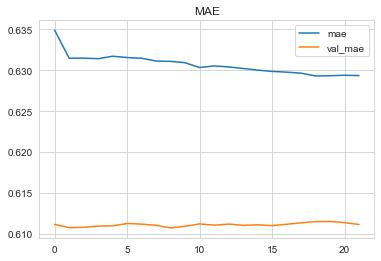

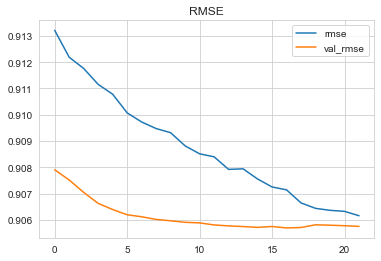

<IPython.core.display.Javascript object>

In [51]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_7.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

##### Model evaluation

In [52]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_7"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(
    X_test_reshaped, y_test, verbose=1
)

534/534 [==============================] - 1s 2ms/step - loss: 0.8060 - mae: 0.5949 - rmse: 0.8978


<IPython.core.display.Javascript object>

In [53]:
# Get pearson score
pearson_score = pearsonr(model_conv1D.predict(X_test_reshaped).reshape(-1), y_test)[0]

# Results in dataframe
df_test_7 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]],
    columns=["model", "loss_test", "mae_test", "rmse_test", "pearson_score"],
)
df_test_7.insert(loc=1, column="epochs", value=len(hist_df_7))
df_test_7

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_7,22,0.805964,0.594889,0.897755,0.08655


<IPython.core.display.Javascript object>

In [54]:
# Concatenate results
df_test_conv = pd.concat([df_test_conv, df_test_7], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

In [55]:
df_test_conv

,model,epochs,loss_test,mae_test,rmse_test,pearson_score
0,Conv1D_1,15,0.805046,0.594623,0.897243,0.094221
1,Conv1D_1_1,21,0.806851,0.596615,0.898249,0.084132
2,Conv1D_scal_1,24,0.806059,0.594119,0.897808,0.084341
3,Conv1D_pca_1,11,0.807132,0.596023,0.898405,0.074178
4,Conv1D_2,9,0.806295,0.597559,0.897939,0.085613
5,Conv1D_3,8,0.805138,0.595649,0.897295,0.089078
6,Conv1D_4,13,0.825270,0.595556,0.897250,0.089660
7,Conv1D_5,19,0.811581,0.597225,0.898702,0.079202
8,Conv1D_6,11,0.802662,0.594800,0.895914,0.105140
9,Conv1D_6_sc,12,0.804695,0.593768,0.897048,0.099570


<IPython.core.display.Javascript object>

So the best model is Conv1D_6.

In [ ]:
images_dir_path = '/content/drive/My Drive/Formation/Dog Classification'
breeds12_data_rep = os.path.join(images_dir_path,'breeds12_data')
breeds12_models_path = os.path.join(breeds12_data_rep, "models")

# Load history 
# From Scratch / GlobalAveragePooling / No Data Augmentation / Batch size 32
hist_csv_file_myGAP_NODA = breeds12_models_path + "/history_my_MobileNetV2.csv"
hist_df_myGAP_NODA = pd.read_csv(hist_csv_file_myGAP_NODA)

# From Scratch / GlobalAveragePooling / Data Augmentation / Batch size 32
hist_csv_file_myGAP_DA = breeds12_models_path + "/history_my_MobileNetV2_2.csv"
hist_df_myGAP_DA = pd.read_csv(hist_csv_file_myGAP_DA)

# GlobalAveragePooling / Data Augmentation / Batch size 32
hist_csv_file_GAP_DA = breeds12_models_path + "/history_MobileNetV2.csv"
hist_df_GAP_DA = pd.read_csv(hist_csv_file_GAP_DA)

In [ ]:
def plot_results(metrics, ymin, ymax) :
    plt.figure(figsize=(13,10))
    accur = ['accuracy','val_accuracy']

    if metrics in accur :
        plt.plot(hist_df_GAP_DA[metrics],
             label='GlobalAv/Data Aug/32 - Max {} : {:.3f}'.format(metrics,
                 np.max(hist_df_GAP_DA[metrics])))
        plt.plot(hist_df_GAP_NODA[metrics],
             label='GlobalAv/NO Data Aug/32 - Max {} : {:.3f}'.format(metrics,
                 np.max(hist_df_GAP_NODA[metrics])))
        plt.plot(hist_df_F_DA[metrics],
             label='Flatten/Data Aug/32 - Max {} : {:.3f}'.format(metrics,
                 np.max(hist_df_F_DA[metrics])))
        plt.plot(hist_df_F_NODA[metrics],
             label='Flatten/NO Data Aug/32 - Max {} : {:.3f}'.format(metrics,
                 np.max(hist_df_F_NODA[metrics])))
        plt.plot(hist_df_myGAP_NODA[metrics],
             label='myGlobalAv/No Data Aug/32 - Max {} : {:.3f}'.format(metrics,
                 np.max(hist_df_myGAP_NODA[metrics])))
        plt.plot(hist_df_myGAP_DA[metrics],
             label='myGlobalAv/Data Aug/32 - Max {} : {:.3f}'.format(metrics,
                 np.max(hist_df_myGAP_DA[metrics])))
    else :
        plt.plot(hist_df_GAP_DA[metrics],
             label='GlobalAv/Data Aug/32 - Min {} : {:.3f}'.format(metrics,
                 np.min(hist_df_GAP_DA[metrics])))
        plt.plot(hist_df_GAP_NODA[metrics],
             label='GlobalAv/NO Data Aug/32 - Min {} : {:.3f}'.format(metrics,
                 np.min(hist_df_GAP_NODA[metrics])))
        plt.plot(hist_df_F_DA[metrics],
             label='Flatten/Data Aug/32 - Min {} : {:.3f}'.format(metrics,
                 np.min(hist_df_F_DA[metrics])))
        plt.plot(hist_df_F_NODA[metrics],
             label='Flatten/NO Data Aug/32 - Min {} : {:.3f}'.format(metrics,
                 np.min(hist_df_F_NODA[metrics])))
        plt.plot(hist_df_myGAP_NODA[metrics],
             label='myGlobalAv/No Data Aug/32 - Min {} : {:.3f}'.format(metrics,
                 np.min(hist_df_myGAP_NODA[metrics])))
        plt.plot(hist_df_myGAP_DA[metrics],
             label='myGlobalAv/Data Aug/32 - Min {} : {:.3f}'.format(metrics,
                 np.min(hist_df_myGAP_DA[metrics])))
    
    plt.title('{} of different MobileNetV2 models over epochs'.format(metrics),
              fontsize=18)
    plt.ylabel(metrics)
    plt.xlabel('epoch')
    plt.ylim(ymin+0.01, ymax+0.01)
    plt.legend()
    plt.show()